<a href="https://colab.research.google.com/github/iamdkshah/Data_Science_Project_23106359/blob/main/D_S_Project_23106359.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up

In [2]:
# Cell 1
from google.colab import drive
drive.mount('/content/drive')
# Install required packages
!pip install numpy pandas matplotlib seaborn optuna shap xgboost lightgbm tensorflow --quiet

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import time
import joblib
import json

# ML libraries
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# DL libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.3 MB/s eta 0:00:00


## Loading Dataset


In [17]:
# Data Loading
import pandas as pd
import numpy as np

# GitHub Raw
DATA_URL = "https://raw.githubusercontent.com/iamdkshah/Data_Science_Project_23106359/refs/heads/main/solar_data_2024.csv"
df = pd.read_csv(DATA_URL, parse_dates=["Timestamp"], low_memory=False)

# Sort + reset
df = df.sort_values("Timestamp").reset_index(drop=True)

print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
print(df.head(5))

Columns: ['Timestamp', 'year', 'jday', 'month', 'day', 'hour', 'minute', 'dt', 'solar_zenith', 'ghi', 'ghi_flag', 'uw_solar', 'uw_solar_flag', 'dni', 'dni_flag', 'dhi', 'dhi_flag', 'dw_ir', 'dw_ir_flag', 'dw_casetemp', 'dw_casetemp_flag', 'dw_dometemp', 'dw_dometemp_flag', 'uw_ir', 'uw_ir_flag', 'uw_casetemp', 'uw_casetemp_flag', 'uw_dometemp', 'uw_dometemp_flag', 'uvb', 'uvb_flag', 'par', 'par_flag', 'netsolar', 'netsolar_flag', 'netir', 'netir_flag', 'totalnet', 'totalnet_flag', 'temp_air', 'temp_air_flag', 'relative_humidity', 'relative_humidity_flag', 'wind_speed', 'wind_speed_flag', 'wind_direction', 'wind_direction_flag', 'pressure', 'pressure_flag']
Shape: (17568, 49)
                  Timestamp    year  jday  month  day  hour  minute        dt  \
0 2024-01-01 00:00:00+00:00  2024.0   1.0    1.0  1.0   0.0    14.5  0.241667   
1 2024-01-01 00:30:00+00:00  2024.0   1.0    1.0  1.0   0.0    44.5  0.741667   
2 2024-01-01 01:00:00+00:00  2024.0   1.0    1.0  1.0   1.0    14.5  1.24

Rows, cols: (17568, 49)
Time span: 2024-01-01 00:00:00+00:00 → 2024-12-31 23:30:00+00:00
Median time step: 0 days 00:30:00

Selected columns for a quick look: ['ghi', 'dni', 'dhi', 'temp_air', 'relative_humidity', 'wind_speed', 'pressure', 'solar_zenith']

Missing (selected):
dni                  408
wind_speed           332
dhi                  197
ghi                  176
temp_air              99
relative_humidity     99
pressure              95
solar_zenith          71
dtype: int64

Summary stats (selected):
                         mean         std         min         50%          max
ghi                161.088189  253.136880   -8.346667    3.906667  1099.720000
dni                157.553698  290.279254   -2.066667    0.100000  1020.486667
dhi                 70.425871  105.623676   -1.230000    4.680000   688.276667
temp_air            11.195451    9.866307  -18.410000   11.286667    34.863333
relative_humidity   70.517096   18.958924   15.370000   73.753333   100.306667
wind_spee

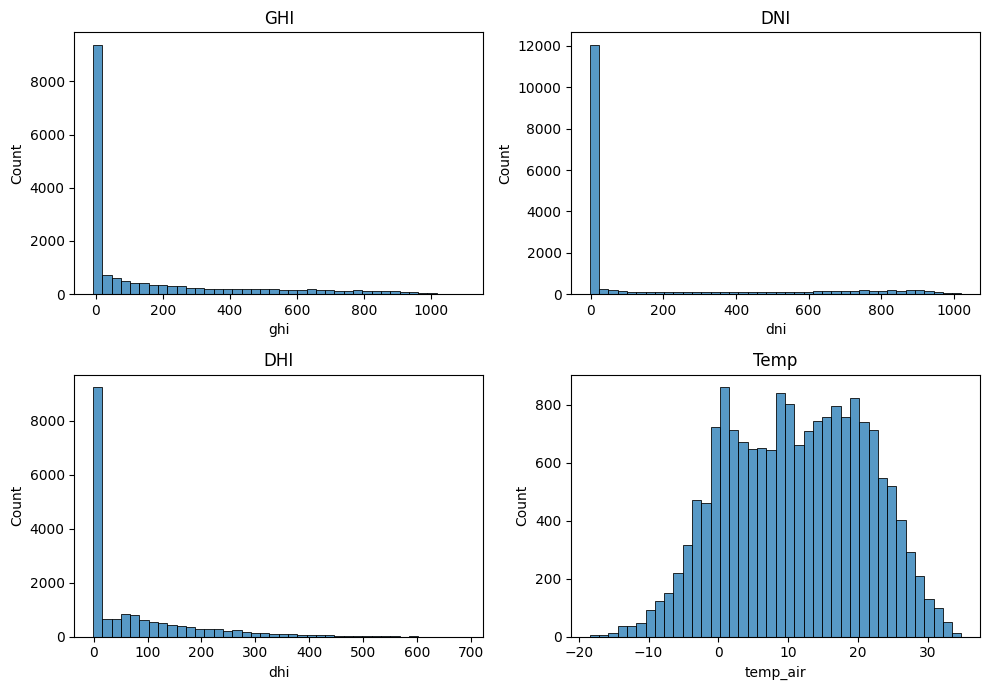

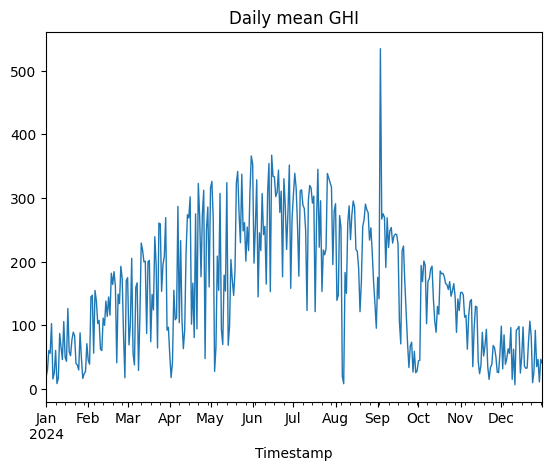

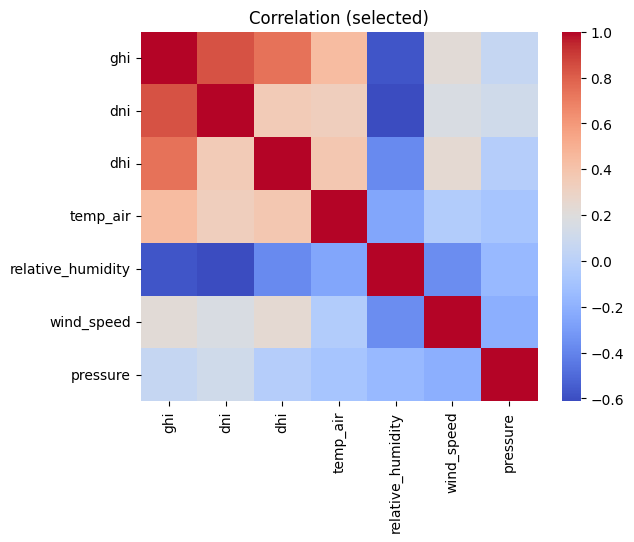

In [18]:
# Cell 3 —  EDA

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_eda = df.copy()

# Basic shape + time range + cadence
print("Rows, cols:", df_eda.shape)
if "Timestamp" in df_eda.columns:
    tmin, tmax = df_eda["Timestamp"].min(), df_eda["Timestamp"].max()
    step_med = (df_eda["Timestamp"].sort_values().diff().dropna().median())
    print("Time span:", tmin, "→", tmax)
    print("Median time step:", step_med)

# Picking required columns for project
cands = {
    "ghi": ["GHI (W/m²)", "ghi"],
    "dni": ["DNI (W/m²)", "dni"],
    "dhi": ["DHI (W/m²)", "dhi"],
    "temp": ["Temp (°C)", "temp_air"],
    "rh": ["RH (%)", "relative_humidity"],
    "ws": ["Wind Speed (m/s)", "wind_speed"],
    "pres": ["Pressure (hPa)", "pressure"],
    "sza": ["Solar Zenith Angle (°)", "solar_zenith"],
}
cols = {}
for k, opts in cands.items():
    for c in opts:
        if c in df_eda.columns:
            cols[k] = c
            break

sel = [c for c in cols.values()]
print("\nSelected columns for a quick look:", sel)

# Missing values + quick stats
if sel:
    print("\nMissing (selected):")
    print(df_eda[sel].isna().sum().sort_values(ascending=False))

    print("\nSummary stats (selected):")
    print(df_eda[sel].describe().T[["mean", "std", "min", "50%", "max"]])

# Distributions
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axlist = axes.ravel()
plots = [("ghi", "GHI"), ("dni", "DNI"), ("dhi", "DHI"), ("temp", "Temp")]
i = 0
for key, title in plots:
    if key in cols:
        sns.histplot(df_eda[cols[key]].dropna(), bins=40, ax=axlist[i])
        axlist[i].set_title(title)
        i += 1
for j in range(i, 4):
    axlist[j].axis("off")
plt.tight_layout()
plt.show()

# Daily pattern (sanity check for seasonality)
if "Timestamp" in df_eda.columns and "ghi" in cols:
    daily_mean = df_eda.set_index("Timestamp")[cols["ghi"]].resample("D").mean()
    daily_mean.plot(title="Daily mean GHI", lw=1)
    plt.show()

# Small correlation heatmap on selected numeric features
num = [cols.get(k) for k in ["ghi", "dni", "dhi", "temp", "rh", "ws", "pres"] if cols.get(k)]
if num:
    corr = df_eda[num].corr()
    sns.heatmap(corr, cmap="coolwarm", annot=False)
    plt.title("Correlation (selected)")
    plt.show()


In [19]:
# Cell 4 — Data Preprocessing: clean daylight series and build next-hour target
import numpy as np
import pandas as pd

# start from df produced in Cell 2
work = df.copy()

# 1) drop all *_flag columns (they're QC flags; we keep only the signals)
work = work[[c for c in work.columns if not c.endswith('_flag')]]

# 2) rename a few core columns to the friendlier names we used before
rename = {
    'ghi': 'GHI (W/m²)',
    'dni': 'DNI (W/m²)',
    'dhi': 'DHI (W/m²)',
    'temp_air': 'Temp (°C)',
    'relative_humidity': 'RH (%)',
    'pressure': 'Pressure (hPa)',
    'wind_speed': 'Wind Speed (m/s)',
    'wind_direction': 'Wind Direction (°)',
    'solar_zenith': 'Solar Zenith Angle (°)'
}
work = work.rename(columns=rename)

# 3) clip to physically plausible ranges
bounds = {
    'GHI (W/m²)': (0, 1400),
    'DNI (W/m²)': (0, 1200),
    'DHI (W/m²)': (0, 800),
    'RH (%)': (0, 100),
    'Temp (°C)': (-40, 50),
    'Pressure (hPa)': (850, 1100),
    'Wind Speed (m/s)': (0, 60),
    'Solar Zenith Angle (°)': (0, 180)
}
for col, (lo, hi) in bounds.items():
    if col in work.columns:
        work[col] = work[col].clip(lower=lo, upper=hi)

# 4) daylight filter (keeps learning focused on sunlit periods)
daylight_mask = False
if 'Solar Zenith Angle (°)' in work.columns:
    daylight_mask = (work['Solar Zenith Angle (°)'] < 90)
for c in ['GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)']:
    if c in work.columns:
        daylight_mask = daylight_mask | (work[c] > 20)

work = work.loc[daylight_mask].sort_values('Timestamp').reset_index(drop=True)

# 5) impute short gaps for numeric columns (light-touch)
num_cols = work.select_dtypes(include=['number']).columns.tolist()
# wind direction is circular; simplest is forward/back fill
if 'Wind Direction (°)' in num_cols:
    num_cols.remove('Wind Direction (°)')

work[num_cols] = (work[num_cols]
                  .interpolate(limit=3)   # small linear fills
                  .bfill(limit=1)
                  .ffill(limit=1))

if 'Wind Direction (°)' in work.columns:
    work['Wind Direction (°)'] = work['Wind Direction (°)'].ffill().bfill()

# 6) build next-hour target (30-min cadence -> shift by 2)
work['Target_GHI_NextHour (W/m²)'] = work['GHI (W/m²)'].shift(-2)
work = work.dropna(subset=['Target_GHI_NextHour (W/m²)']).reset_index(drop=True)

# 7) simple time features for all models
work['hour_float'] = work['Timestamp'].dt.hour + work['Timestamp'].dt.minute/60.0
work['hour_sin'] = np.sin(2*np.pi*work['hour_float']/24.0)
work['hour_cos'] = np.cos(2*np.pi*work['hour_float']/24.0)
work['doy'] = work['Timestamp'].dt.dayofyear
work['doy_sin'] = np.sin(2*np.pi*work['doy']/365.0)
work['doy_cos'] = np.cos(2*np.pi*work['doy']/365.0)

# 8) quick sanity print
print("After cleaning (daylight only):", work.shape)
print("Remaining NaNs (top 8):")
print(work.isna().sum().sort_values(ascending=False).head(8))

# 9) save a clean base (no labels yet). We'll create labels later in a separate cell.
CLEAN_PATH = "/content/solar_data_2024_30min_clean.csv"
work.to_csv(CLEAN_PATH, index=False)
print("Saved cleaned base to:", CLEAN_PATH)

# peek
display(work.head())


After cleaning (daylight only): (8775, 36)
Remaining NaNs (top 8):
totalnet      74
uvb           64
uw_solar      61
DHI (W/m²)    61
netsolar      61
DNI (W/m²)    61
dw_ir         13
netir         13
dtype: int64
Saved cleaned base to: /content/solar_data_2024_30min_clean.csv


,Timestamp,year,jday,month,day,hour,minute,dt,Solar Zenith Angle (°),GHI (W/m²),...,Wind Speed (m/s),Wind Direction (°),Pressure (hPa),Target_GHI_NextHour (W/m²),hour_float,hour_sin,hour_cos,doy,doy_sin,doy_cos
0,2024-01-01 12:30:00+00:00,2024.0,1.0,1.0,1.0,12.0,44.5,12.741667,89.173333,2.073333,...,0.566667,244.816667,971.750000,28.610000,12.5,-0.130526,-0.991445,1,0.017213,0.999852
1,2024-01-01 13:00:00+00:00,2024.0,1.0,1.0,1.0,13.0,14.5,13.241667,84.632667,15.190000,...,1.073333,242.850000,971.983333,54.383333,13.0,-0.258819,-0.965926,1,0.017213,0.999852
2,2024-01-01 13:30:00+00:00,2024.0,1.0,1.0,1.0,13.0,44.5,13.741667,80.306667,28.610000,...,2.053333,237.193333,972.303333,96.816667,13.5,-0.382683,-0.923880,1,0.017213,0.999852
3,2024-01-01 14:00:00+00:00,2024.0,1.0,1.0,1.0,14.0,14.5,14.241667,76.306000,54.383333,...,2.606667,247.283333,972.623333,238.410000,14.0,-0.500000,-0.866025,1,0.017213,0.999852
4,2024-01-01 14:30:00+00:00,2024.0,1.0,1.0,1.0,14.0,44.5,14.741667,72.726333,96.816667,...,3.070000,255.060000,972.840000,61.920000,14.5,-0.608761,-0.793353,1,0.017213,0.999852


In [20]:
# Cell 5 — feature engineering on the cleaned daylight data in `work`
import numpy as np
import pandas as pd

fe = work.copy()  # work comes from Cell 4

# 1) keep core signals (drop the miscellaneous long-tail radiation channels)
core_keep = [
    'Timestamp',
    'GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)',
    'Temp (°C)', 'RH (%)', 'Pressure (hPa)',
    'Wind Speed (m/s)', 'Wind Direction (°)',
    'Solar Zenith Angle (°)',
    'hour_float', 'hour_sin', 'hour_cos', 'doy', 'doy_sin', 'doy_cos',
    'Target_GHI_NextHour (W/m²)'
]
fe = fe[[c for c in core_keep if c in fe.columns]].sort_values('Timestamp').reset_index(drop=True)

# 2) cloudiness proxies (safe, bounded)
eps = 1e-6
gh = fe['GHI (W/m²)'].clip(lower=0) + eps
fe['diffuse_fraction'] = (fe['DHI (W/m²)'].clip(lower=0) / gh).clip(0, 1.2)   # a bit >1 possible under very cloudy spikes
fe['beam_fraction']    = (1.0 - fe['diffuse_fraction']).clip(0, 1.0)

# 3) lags & rolling means for a small set of variables
lag_cols = ['GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)',
            'Temp (°C)', 'RH (%)', 'Pressure (hPa)', 'Wind Speed (m/s)']

for c in lag_cols:
    fe[f'{c}_lag1'] = fe[c].shift(1)
    fe[f'{c}_lag2'] = fe[c].shift(2)

roll3 = fe[lag_cols].rolling(window=3, min_periods=1).mean().add_suffix('_roll3_mean')
roll6 = fe[lag_cols].rolling(window=6, min_periods=1).mean().add_suffix('_roll6_mean')
fe = pd.concat([fe, roll3, roll6], axis=1)

# 4) first differences (recent change)
for c in ['GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)']:
    fe[f'{c}_diff1'] = fe[c].diff(1)

# 5) drop rows made NaN by lags/rolling (first ~2 rows)
before = len(fe)
fe = fe.dropna().reset_index(drop=True)
dropped = before - len(fe)

print(f'Dropped {dropped} rows due to lags/rollings; remaining {len(fe)}')
print('Num features:', fe.shape[1])

# 6) save feature set for next steps (labels, split, models)
FEAT_PATH = "/content/solar_data_2024_30min_features.csv"
fe.to_csv(FEAT_PATH, index=False)
print("Saved features to:", FEAT_PATH)

display(fe.head(3))


Dropped 86 rows due to lags/rollings; remaining 8689
Num features: 50
Saved features to: /content/solar_data_2024_30min_features.csv


,Timestamp,GHI (W/m²),DNI (W/m²),DHI (W/m²),Temp (°C),RH (%),Pressure (hPa),Wind Speed (m/s),Wind Direction (°),Solar Zenith Angle (°),...,GHI (W/m²)_roll6_mean,DNI (W/m²)_roll6_mean,DHI (W/m²)_roll6_mean,Temp (°C)_roll6_mean,RH (%)_roll6_mean,Pressure (hPa)_roll6_mean,Wind Speed (m/s)_roll6_mean,GHI (W/m²)_diff1,DNI (W/m²)_diff1,DHI (W/m²)_diff1
0,2024-01-01 13:30:00+00:00,28.610000,0.226667,28.773333,0.186667,98.446667,972.303333,2.053333,237.193333,80.306667,...,15.291111,0.247778,15.723333,0.046667,98.463333,972.012222,1.231111,13.420000,0.010000,13.220000
1,2024-01-01 14:00:00+00:00,54.383333,0.273333,54.273333,0.676667,95.873333,972.623333,2.606667,247.283333,76.306000,...,25.064167,0.254167,25.360833,0.204167,97.815833,972.165000,1.575000,25.773333,0.046667,25.500000
2,2024-01-01 14:30:00+00:00,96.816667,0.310000,96.016667,1.086667,89.483333,972.840000,3.070000,255.060000,72.726333,...,39.414667,0.265333,39.492000,0.380667,96.149333,972.300000,1.874000,42.433333,0.036667,41.743333


## Data split



In [21]:
# Cell 6 — labels + time-safe split
import numpy as np
import pandas as pd

# If you just ran Cell 5 you already have `fe` in memory.
# Otherwise uncomment the next 2 lines to reload the features we saved.
# FEAT_PATH = "/content/solar_data_2024_30min_features.csv"
# fe = pd.read_csv(FEAT_PATH, parse_dates=["Timestamp"])

df = fe.copy().sort_values("Timestamp").reset_index(drop=True)

# ---- 1) wind direction is circular: convert to components, then drop raw angle
if {"Wind Speed (m/s)", "Wind Direction (°)"}.issubset(df.columns):
    rad = np.deg2rad(df["Wind Direction (°)"].clip(0, 360))
    df["wind_u"] = df["Wind Speed (m/s)"] * np.sin(rad)
    df["wind_v"] = df["Wind Speed (m/s)"] * np.cos(rad)
    df = df.drop(columns=["Wind Direction (°)"], errors="ignore")

# ---- 2) choose label mode
# "fixed": bins you used earlier (imbalanced, realistic)
# "adaptive": tertiles learned from the TRAIN split only (balanced)
LABEL_MODE = "fixed"   # change to "adaptive" if you want balanced classes

target_reg = "Target_GHI_NextHour (W/m²)"

# time-safe split: last 20% as test (no shuffling)
test_size = 0.20
split_idx = int((1 - test_size) * len(df))
df_train = df.iloc[:split_idx].copy()
df_test  = df.iloc[split_idx:].copy()

# ---- 3) build labels
labels = ["Low", "Medium", "High"]

if LABEL_MODE == "fixed":
    # Keep exactly what we printed when creating the CSVs
    bins = [0, 250, 600, np.inf]
    df_train["ghi_category"] = pd.cut(df_train[target_reg], bins=bins, labels=labels, include_lowest=True)
    df_test["ghi_category"]  = pd.cut(df_test[target_reg],  bins=bins, labels=labels, include_lowest=True)

elif LABEL_MODE == "adaptive":
    # Learn cutpoints on TRAIN ONLY (no leakage), then apply to test
    q33 = float(df_train[target_reg].quantile(1/3))
    q66 = float(df_train[target_reg].quantile(2/3))
    bins = [0, max(1e-6, q33), max(q33 + 1e-6, q66), np.inf]
    df_train["ghi_category"] = pd.cut(df_train[target_reg], bins=bins, labels=labels, include_lowest=True)
    df_test["ghi_category"]  = pd.cut(df_test[target_reg],  bins=bins, labels=labels, include_lowest=True)
else:
    raise ValueError("LABEL_MODE must be 'fixed' or 'adaptive'")

# small sanity check
print("Split index:", split_idx, "| train rows:", len(df_train), "| test rows:", len(df_test))
print("\nTrain class counts:")
print(df_train["ghi_category"].value_counts(dropna=False))
print("\nTest class counts:")
print(df_test["ghi_category"].value_counts(dropna=False))

# ---- 4) select feature columns (drop non-features + label + timestamp)
drop_cols = {"Timestamp", target_reg, "ghi_category"}
X_cols = [c for c in df.columns if c not in drop_cols]

X_train = df_train[X_cols].to_numpy()
y_train = df_train["ghi_category"].astype("category").cat.codes.to_numpy()  # Low=0, Medium=1, High=2
X_test  = df_test[X_cols].to_numpy()
y_test  = df_test["ghi_category"].astype("category").cat.codes.to_numpy()

# class weights for imbalanced training (used by XGBClassifier later)
from collections import Counter
cnt = Counter(y_train)
n_total = len(y_train)
n_cls = len(cnt)
class_weight = {k: n_total / (n_cls * v) for k, v in cnt.items()}
print("\nEncoded classes (0,1,2) ->", df_train["ghi_category"].astype("category").cat.categories.tolist())
print("Class weights:", class_weight)

# ---- 5) stash everything for the next cells
data_pack = {
    "X_cols": X_cols,
    "X_train": X_train, "y_train": y_train,
    "X_test":  X_test,  "y_test":  y_test,
    "train_df": df_train, "test_df": df_test,
    "bins_used": bins, "label_mode": LABEL_MODE
}
print("\nFeatures ready. X_train/X_test shapes:", X_train.shape, X_test.shape)


Split index: 6951 | train rows: 6951 | test rows: 1738

Train class counts:
ghi_category
Low       3367
Medium    1978
High      1606
Name: count, dtype: int64

Test class counts:
ghi_category
Low       1093
Medium     557
High        88
Name: count, dtype: int64

Encoded classes (0,1,2) -> ['Low', 'Medium', 'High']
Class weights: {np.int8(0): 0.6881496881496881, np.int8(1): 1.1713852376137512, np.int8(2): 1.4427148194271482}

Features ready. X_train/X_test shapes: (6951, 49) (1738, 49)


## Model 1: LightGBM

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

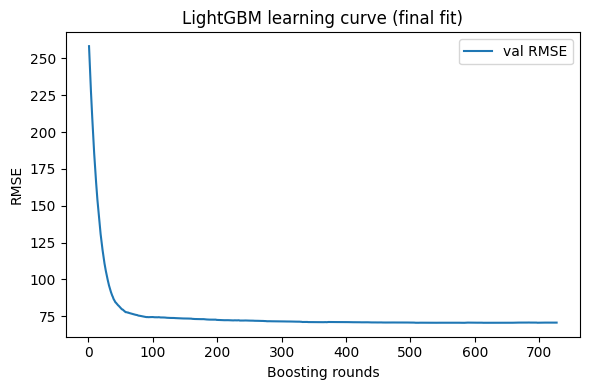

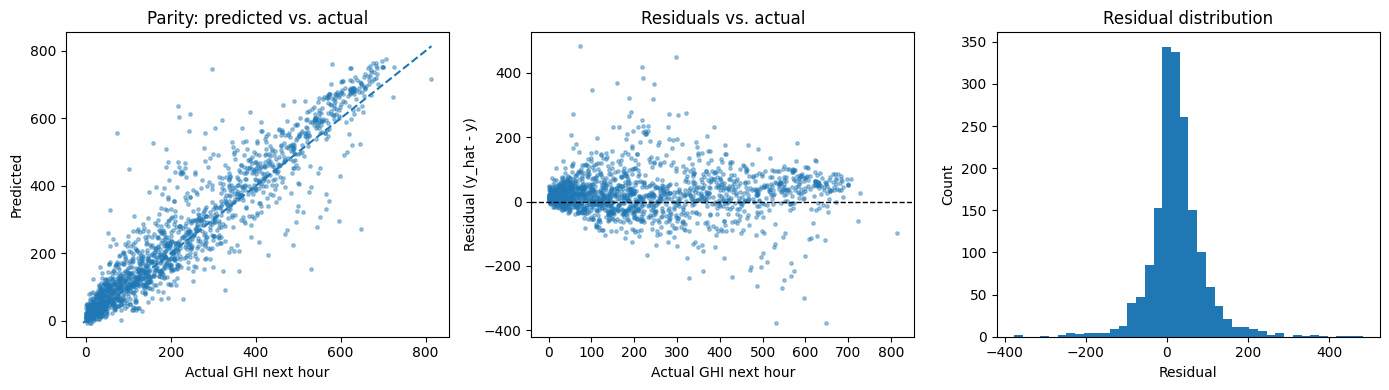

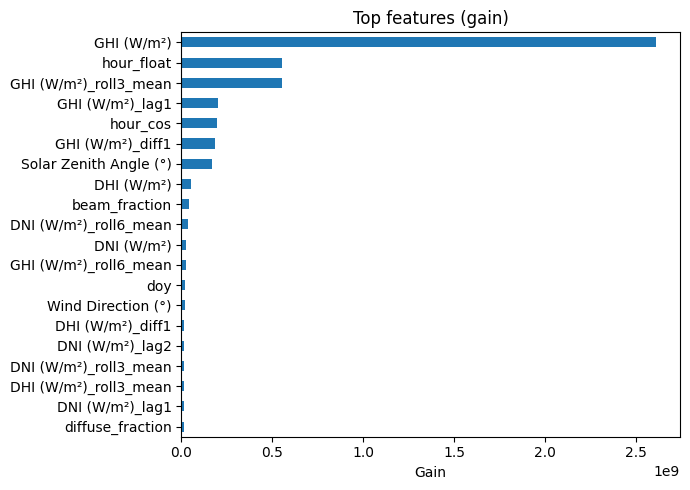


=== Test confusion matrix on binned predictions (Low/Med/High) ===
[[987 103   3]
 [ 51 446  60]
 [  0   8  80]]


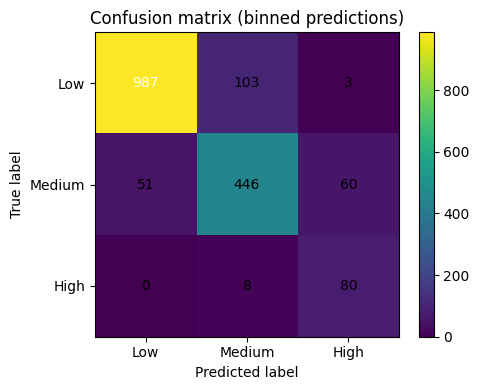


=== Classification report (binned) ===
              precision    recall  f1-score   support

         Low     0.9509    0.9030    0.9263      1093
      Medium     0.8007    0.8007    0.8007       557
        High     0.5594    0.9091    0.6926        88

    accuracy                         0.8705      1738
   macro avg     0.7703    0.8709    0.8066      1738
weighted avg     0.8829    0.8705    0.8742      1738


Benchmarks appended → model_benchmarks.csv


In [ ]:
# LightGBM Regressor — next-hour GHI, time-safe CV, early stopping, full analysis
# What this does:
# 1) Load the engineered features CSV you saved earlier (chronological order).
# 2) Make the same 80/20 time-safe split you used before (first 80% train, last 20% test).
# 3) Random-search hyperparameters with TimeSeriesSplit CV and early stopping on each fold.
# 4) Refit the best model on all training data with a small tail used as validation for early stopping.
# 5) Report regression metrics (RMSE, MAE, MAPE, R2), show learning curves and diagnostic plots.
# 6) Convert predictions to Low/Medium/High bins → confusion matrix + classification metrics (for your report).
# 7) Save tuning history (CSV) and append a row to model_benchmarks.csv.

import time
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, ParameterSampler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    classification_report, confusion_matrix
)

import lightgbm as lgb

# ------------------------------
# 0) Small helpers
# ------------------------------
def rmse(y_true, y_pred):
    # manual RMSE to be compatible with older sklearn versions
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mape_safe(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true, dtype=np.float64)
    y_pred = np.asarray(y_pred, dtype=np.float64)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def bin_fixed(y, edges=(0, 250, 600, np.inf)):
    # Same bins as your classification track
    # 0:[0,250), 1:[250,600), 2:[600,inf)
    y = np.asarray(y, dtype=np.float64)
    return np.digitize(y, bins=edges[1:-1], right=False).astype(np.int8)

def plot_confmat(cm, class_names, title="Confusion matrix"):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names, yticklabels=class_names,
        ylabel='True label', xlabel='Predicted label',
        title=title
    )
    # print numbers on squares
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# ------------------------------
# 1) Load engineered features and make time-safe split
# ------------------------------
FEAT_CSV = "/content/solar_data_2024_30min_features.csv"
TARGET   = "Target_GHI_NextHour (W/m²)"

df_feat = pd.read_csv(FEAT_CSV, parse_dates=["Timestamp"]).sort_values("Timestamp").reset_index(drop=True)

drop_cols = ["Timestamp", TARGET]
if "ghi_category" in df_feat.columns:  # in case you kept it for classification track
    drop_cols.append("ghi_category")

X_cols = [c for c in df_feat.columns if c not in drop_cols]
X_all = df_feat[X_cols].copy()
y_all = df_feat[TARGET].astype(np.float32).copy()

n = len(df_feat)                 # you saw ~8689 in your earlier run
split_idx = int(0.8 * n)        # 80/20 time-safe split: 6951 / 1738 previously

X_train_df = X_all.iloc[:split_idx].reset_index(drop=True)
y_train    = y_all.iloc[:split_idx].reset_index(drop=True)
X_test_df  = X_all.iloc[split_idx:].reset_index(drop=True)
y_test     = y_all.iloc[split_idx:].reset_index(drop=True)

print(f"LightGBM regression — feature matrix shapes: {X_train_df.shape} {X_test_df.shape}")

# ------------------------------
# 2) Baseline (persistence): predict next-hour GHI ≈ current GHI
# ------------------------------
if "GHI (W/m²)" in X_test_df.columns:
    y_pred_persist = X_test_df["GHI (W/m²)"].to_numpy(np.float32)
    rmse_persist   = rmse(y_test, y_pred_persist)
    mae_persist    = mean_absolute_error(y_test, y_pred_persist)
    mape_persist   = mape_safe(y_test, y_pred_persist)
    r2_persist     = r2_score(y_test, y_pred_persist)
    print("\n=== Persistence baseline (predict next ≈ current GHI) ===")
    print(f"RMSE: {rmse_persist:.2f} | MAE: {mae_persist:.2f} | MAPE: {mape_persist:.2f}% | R²: {r2_persist:.3f}")
else:
    print("\n(Persistence baseline skipped: 'GHI (W/m²)' not in feature set.)")
    rmse_persist = mae_persist = mape_persist = r2_persist = np.nan

# ------------------------------
# 3) Random search with time-series CV + early stopping
# ------------------------------
# Keep the space sensible; LGBM is fast enough that 40–60 trials is OK for this dataset.
search_space = {
    "learning_rate":   [0.05, 0.08, 0.10, 0.15],
    "max_depth":       [3, 4, 5, 6, -1],
    "num_leaves":      [15, 31, 63, 127],
    "min_child_samples":[5, 10, 20, 40],
    "subsample":       [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree":[0.6, 0.7, 0.8, 1.0],
    "reg_alpha":       [0.0, 0.1, 0.3, 0.6],
    "reg_lambda":      [0.0, 0.5, 1.0, 5.0, 10.0],
    # big n_estimators; early stopping will determine the best one
    "n_estimators":    [1500],
    # optional: max_bin can matter with continuous features
    "max_bin":         [255, 511],
}

tscv = TimeSeriesSplit(n_splits=4)
n_iter = 40
rng = np.random.RandomState(42)

history = []
best_rmse = np.inf
best_params = None
best_mean_iter = None

t_tune_start = time.time()
for i, params in enumerate(ParameterSampler(search_space, n_iter=n_iter, random_state=rng), 1):
    fold_rmses = []
    fold_best_its = []

    for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_train_df), 1):
        X_tr, X_va = X_train_df.iloc[tr_idx], X_train_df.iloc[va_idx]
        y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        # set up model; keep eval metric to l2 (RMSE)
        model = lgb.LGBMRegressor(
            objective="regression",
            metric="l2",
            boosting_type="gbdt",
            random_state=2024,
            n_jobs=-1,
            **params
        )

        # use LightGBM callbacks for early stopping; record evals for possible debugging
        evals_result = {}
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="l2",
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.log_evaluation(period=0),
                lgb.record_evaluation(evals_result)
            ]
        )

        y_va_hat = model.predict(X_va, num_iteration=model.best_iteration_)
        fold_rmses.append(rmse(y_va, y_va_hat))
        fold_best_its.append(getattr(model, "best_iteration_", params["n_estimators"]))

    mean_rmse = float(np.mean(fold_rmses))
    mean_iter = int(np.mean(fold_best_its))
    history.append({"iter": i, "mean_rmse": mean_rmse, "mean_best_iter": mean_iter, **params})
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = params
        best_mean_iter = mean_iter

    if i % 5 == 0 or i == n_iter:
        print(f"[{i:02d}/{n_iter}] CV RMSE(best so far): {best_rmse:.2f}")

t_tune = time.time() - t_tune_start
print("\nBest CV RMSE:", round(best_rmse, 2))
print("Best params:", json.dumps(best_params, indent=2))
print("Avg early-stopped best_iteration across folds:", best_mean_iter)
pd.DataFrame(history).to_csv("lgbm_tuning_history.csv", index=False)
print("Tuning history saved → lgbm_tuning_history.csv")

# ------------------------------
# 4) Refit best model on ALL training (use a small tail for ES)
# ------------------------------
# hold out last 10% of training for early stopping
cut = int(0.9 * len(X_train_df))
X_tr2, y_tr2 = X_train_df.iloc[:cut], y_train.iloc[:cut]
X_va2, y_va2 = X_train_df.iloc[cut:], y_train.iloc[cut:]

final = lgb.LGBMRegressor(
    objective="regression",
    metric="l2",
    boosting_type="gbdt",
    random_state=2024,
    n_jobs=-1,
    **best_params
)

final_evals = {}
t_fit = time.time()
final.fit(
    X_tr2, y_tr2,
    eval_set=[(X_va2, y_va2)],
    eval_metric="l2",
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=0),
        lgb.record_evaluation(final_evals),
    ]
)
t_fit = time.time() - t_fit
best_iter_final = getattr(final, "best_iteration_", best_params["n_estimators"])
print("\nBest iteration (final):", best_iter_final)

# ------------------------------
# 5) Evaluate on test
# ------------------------------
t_pred = time.time()
y_hat = final.predict(X_test_df, num_iteration=best_iter_final)
t_pred = time.time() - t_pred

rmse_test = rmse(y_test, y_hat)
mae_test  = mean_absolute_error(y_test, y_hat)
mape_test = mape_safe(y_test, y_hat)
r2_test   = r2_score(y_test, y_hat)

print("\n=== LightGBM Regressor — Test ===")
print(f"RMSE: {rmse_test:.2f} | MAE: {mae_test:.2f} | MAPE: {mape_test:.2f}% | R²: {r2_test:.3f}")
if not np.isnan(rmse_persist):
    gain = (rmse_persist - rmse_test) / rmse_persist * 100.0
    print(f"vs Persistence: RMSE improved by {gain:.1f}%")

# ------------------------------
# 6) Learning curve (from final fit)
# ------------------------------
if "valid_0" in final_evals and "l2" in final_evals["valid_0"]:
    tr_l2 = np.array(final_evals.get("training", {}).get("l2", []), dtype=float)
    va_l2 = np.array(final_evals["valid_0"]["l2"], dtype=float)
    iters = np.arange(1, len(va_l2)+1)

    plt.figure(figsize=(6,4))
    if len(tr_l2):
        plt.plot(iters, np.sqrt(tr_l2), label="train RMSE")
    plt.plot(iters, np.sqrt(va_l2), label="val RMSE")
    plt.xlabel("Boosting rounds")
    plt.ylabel("RMSE")
    plt.title("LightGBM learning curve (final fit)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------
# 7) Parity plot, residual plot, error histogram
# ------------------------------
fig, ax = plt.subplots(1, 3, figsize=(14,4))

# (a) parity
lim_min = min(np.min(y_test), np.min(y_hat))
lim_max = max(np.max(y_test), np.max(y_hat))
ax[0].scatter(y_test, y_hat, s=6, alpha=0.4)
ax[0].plot([lim_min, lim_max], [lim_min, lim_max], linestyle="--")
ax[0].set_title("Parity: predicted vs. actual")
ax[0].set_xlabel("Actual GHI next hour")
ax[0].set_ylabel("Predicted")

# (b) residuals vs. actual
resid = y_hat - y_test
ax[1].scatter(y_test, resid, s=6, alpha=0.4)
ax[1].axhline(0, color="k", linestyle="--", linewidth=1)
ax[1].set_title("Residuals vs. actual")
ax[1].set_xlabel("Actual GHI next hour")
ax[1].set_ylabel("Residual (y_hat - y)")

# (c) residual histogram
ax[2].hist(resid, bins=40)
ax[2].set_title("Residual distribution")
ax[2].set_xlabel("Residual")
ax[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

# ------------------------------
# 8) Feature importance (gain)
# ------------------------------
try:
    booster = final.booster_ if hasattr(final, "booster_") else final.booster_
    gain = booster.feature_importance(importance_type="gain")
    fi = pd.Series(gain, index=X_cols).sort_values(ascending=False)
    top = fi.head(20)

    plt.figure(figsize=(7,5))
    top[::-1].plot(kind="barh")
    plt.title("Top features (gain)")
    plt.xlabel("Gain")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Feature importance plot skipped:", e)

# ------------------------------
# 9) For the report: bin predictions → confusion matrix & classification scores
# ------------------------------
bins = (0, 250, 600, np.inf)
y_true_cls = bin_fixed(y_test, edges=bins)
y_pred_cls = bin_fixed(y_hat,  edges=bins)

cm = confusion_matrix(y_true_cls, y_pred_cls, labels=[0,1,2])
print("\n=== Test confusion matrix on binned predictions (Low/Med/High) ===")
print(cm)
plot_confmat(cm, class_names=["Low","Medium","High"], title="Confusion matrix (binned predictions)")

print("\n=== Classification report (binned) ===")
print(classification_report(y_true_cls, y_pred_cls, target_names=["Low","Medium","High"], digits=4))

# ------------------------------
# 10) Save benchmark row + tuning history already saved
# ------------------------------
bench_path = "model_benchmarks.csv"
row = pd.DataFrame([{
    "track": "regression",
    "model": "LGBMRegressor",
    "cv_metric": "RMSE",
    "cv_best": best_rmse,
    "test_RMSE": rmse_test,
    "test_MAE": mae_test,
    "test_MAPE_pct": mape_test,
    "test_R2": r2_test,
    "acc_binned": None,  # regression primary; binned scores below if you want to keep them
    "macroF1_binned": None,
    "weightedF1_binned": None,
    "fit_time_sec": round(t_fit, 3),
    "pred_time_sec": round(t_pred, 3),
    "best_iter": best_iter_final,
    "best_params": json.dumps(best_params)
}])

try:
    old = pd.read_csv(bench_path)
    bench = pd.concat([old, row], ignore_index=True)
except Exception:
    bench = row

bench.to_csv(bench_path, index=False)
print("\nBenchmarks appended →", bench_path)


## Model 2: XGBClassifier

XGBoost version: 3.0.4
Train/Test: (6951, 49) (1738, 49)
Class weights (train): {0: 0.6251644253908227, 1: 1.06417018214909, 2: 1.3106653924600873}

=== Persistence baseline (bin of current GHI) ===
Accuracy   : 0.7819
Macro-F1   : 0.6863
Weighted-F1: 0.7820

Report:
               precision    recall  f1-score   support

         Low       0.86      0.86      0.86      1093
      Medium       0.66      0.66      0.66       557
        High       0.53      0.53      0.53        88

    accuracy                           0.78      1738
   macro avg       0.69      0.69      0.69      1738
weighted avg       0.78      0.78      0.78      1738



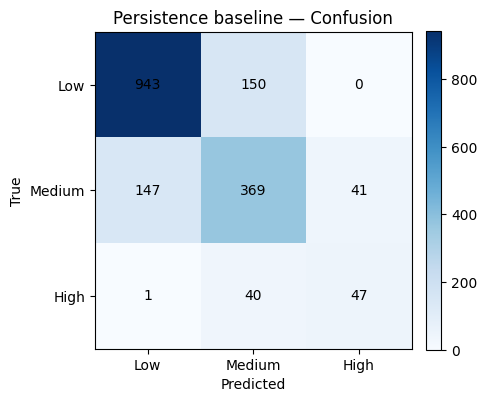

In [ ]:
# keep imports local to this block so the cell reads self-contained
import time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import LabelBinarizer

import xgboost as xgb

# ---- sanity checks from earlier cells ----
print("XGBoost version:", xgb.__version__)
print("Train/Test:", X_train.shape, X_test.shape)

# Small helpers I’ll reuse
def class_weights_from_counts(y):
    """inverse-frequency weights per class (dict: class_idx -> weight)"""
    counts = pd.Series(y).value_counts().sort_index()
    w = (counts.sum() / counts).to_dict()
    # normalize to mean 1.0 (nicer scale)
    mean_w = np.mean(list(w.values()))
    w = {k: float(v / mean_w) for k, v in w.items()}
    return w

def onehot(y, n_classes=3):
    lb = LabelBinarizer()
    lb.fit(range(n_classes))
    return lb.transform(y)

def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def report_block(y_true, y_pred, title):
    acc   = accuracy_score(y_true, y_pred)
    f1_ma = f1_score(y_true, y_pred, average="macro")
    f1_wt = f1_score(y_true, y_pred, average="weighted")
    print(f"\n=== {title} ===")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Macro-F1   : {f1_ma:.4f}")
    print(f"Weighted-F1: {f1_wt:.4f}")
    print("\nReport:\n", classification_report(y_true, y_pred, target_names=["Low","Medium","High"]))
    return {"accuracy":acc, "macro_f1":f1_ma, "weighted_f1":f1_wt}

def plot_confmat(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    fig, ax = plt.subplots(figsize=(4.8,4.2))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
    ax.set_xticklabels(["Low","Medium","High"])
    ax.set_yticklabels(["Low","Medium","High"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

# We’ll need a quick way to grab a feature column by name even if X_* are arrays.
def get_col(arr_or_df, colname, feature_names):
    if hasattr(arr_or_df, "loc"):
        return arr_or_df[colname].to_numpy()
    idx = feature_names.index(colname)
    return arr_or_df[:, idx]

# Class weights from *your* train set (time-safe)
cls_w = class_weights_from_counts(y_train)
print("Class weights (train):", cls_w)

# ---- (optional but useful) Persistence baseline: "bin current GHI" ----
# If your features include raw current GHI, we can baseline against a simple rule.
baseline_scores = None
if "GHI (W/m²)" in X_cols:
    ghi_now_test = get_col(X_test, "GHI (W/m²)", X_cols)
    y_baseline = np.where(ghi_now_test < 250, 0, np.where(ghi_now_test < 600, 1, 2)).astype(np.int8)
    baseline_scores = report_block(y_test, y_baseline, "Persistence baseline (bin of current GHI)")
    plot_confmat(y_test, y_baseline, "Persistence baseline — Confusion")
else:
    print("Note: raw 'GHI (W/m²)' not in X_cols → skipping persistence baseline.")

# To make feature names usable with XGB’s importance later, convert to DataFrame once here.
Xtr_df = pd.DataFrame(X_train, columns=X_cols)
Xte_df = pd.DataFrame(X_test,  columns=X_cols)


XGBoost version: 3.0.4
[05/30] CV macro-F1(best so far): 0.784
[10/30] CV macro-F1(best so far): 0.789
[15/30] CV macro-F1(best so far): 0.791
[20/30] CV macro-F1(best so far): 0.791
[25/30] CV macro-F1(best so far): 0.791
[30/30] CV macro-F1(best so far): 0.791

Best CV macro-F1: 0.791
Best params: {'subsample': np.float64(0.95), 'reg_lambda': 10.0, 'reg_alpha': 0.1, 'min_child_weight': np.float64(2.0), 'max_depth': 4, 'learning_rate': 0.1, 'gamma': np.float64(1.0), 'colsample_bytree': np.float64(0.6)}
Avg early-stopped rounds (CV): 91
Tuning time: 356.5s


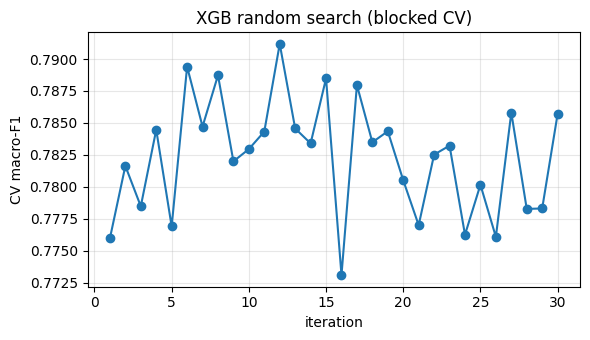

In [ ]:
# Cell 8 — CV + random search with version-proof early stopping
import time, json
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import f1_score

print("XGBoost version:", xgb.__version__)

# ---- helpers we need ONLY here ----
def blocked_cv_indices(n_rows, n_splits=4):
    """Contiguous forward folds (no shuffling) to respect time order."""
    fold_sizes = np.full(n_splits, n_rows // n_splits, dtype=int)
    fold_sizes[: n_rows % n_splits] += 1
    idx = np.arange(n_rows)
    cur = 0
    blocks = []
    for fs in fold_sizes:
        blocks.append(idx[cur:cur+fs])
        cur += fs
    for i in range(n_splits):
        val = blocks[i]
        tr  = np.concatenate(blocks[:i]) if i > 0 else np.array([], dtype=int)
        if tr.size == 0:  # skip the first empty-train fold
            continue
        yield tr, val

class _BoosterWrap:
    """Make xgb.train booster look like sklearn estimator for our code path."""
    def __init__(self, booster):
        self._booster = booster
        # xgb.train sets either best_ntree_limit or best_iteration
        self.best_iteration_ = getattr(booster, "best_iteration", None)
    def predict_proba(self, X):
        d = xgb.DMatrix(np.asarray(X))
        return self._booster.predict(d)
    def predict(self, X):
        P = self.predict_proba(X)
        return P.argmax(axis=1)
    def evals_result(self):
        try:
            return self._booster.evals_result()
        except Exception:
            return {}
    def get_booster(self):
        return self._booster

def _fit_with_es(model, Xtr, ytr, wtr, Xva, yva, es_rounds):
    """Try several ways to do early stopping depending on XGBoost version."""
    # try 1: sklearn API with early_stopping_rounds
    try:
        model.fit(
            Xtr, ytr,
            sample_weight=wtr,
            eval_set=[(Xva, yva)],
            early_stopping_rounds=es_rounds,
            verbose=False
        )
        return model
    except TypeError:
        pass

    # try 2: sklearn API with callbacks
    try:
        from xgboost.callback import EarlyStopping
        cb = [EarlyStopping(rounds=es_rounds, save_best=True)]
        model.fit(
            Xtr, ytr,
            sample_weight=wtr,
            eval_set=[(Xva, yva)],
            callbacks=cb,
            verbose=False
        )
        return model
    except Exception:
        pass

    # try 3: native xgb.train with DMatrix and early_stopping_rounds
    dtr = xgb.DMatrix(np.asarray(Xtr), label=ytr, weight=wtr)
    dva = xgb.DMatrix(np.asarray(Xva), label=yva)
    # translate sklearn params to booster params
    p = {
        "objective": "multi:softprob",
        "num_class": 3,
        "tree_method": "hist",
        "eval_metric": "mlogloss",
        "eta": model.get_params().get("learning_rate", 0.1),
        "max_depth": model.get_params().get("max_depth", 6),
        "min_child_weight": model.get_params().get("min_child_weight", 1.0),
        "subsample": model.get_params().get("subsample", 1.0),
        "colsample_bytree": model.get_params().get("colsample_bytree", 1.0),
        "gamma": model.get_params().get("gamma", 0.0),
        "alpha": model.get_params().get("reg_alpha", 0.0),
        "lambda": model.get_params().get("reg_lambda", 1.0),
        "verbosity": 0,
    }
    num_round = model.get_params().get("n_estimators", 2000)
    booster = xgb.train(
        p, dtr, num_boost_round=num_round,
        evals=[(dtr, "train"), (dva, "validation_0")],
        early_stopping_rounds=es_rounds,
        verbose_eval=False
    )
    return _BoosterWrap(booster)

def _macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def cv_score(params, X_df, y, n_splits=4, early_rounds=200, class_weight_dict=None):
    f1s, rounds = [], []
    for tr_idx, va_idx in blocked_cv_indices(len(X_df), n_splits=n_splits):
        Xtr, Xva = X_df.iloc[tr_idx], X_df.iloc[va_idx]
        ytr, yva = y[tr_idx], y[va_idx]
        wtr = np.vectorize(class_weight_dict.get)(ytr) if class_weight_dict else None

        model = xgb.XGBClassifier(
            objective="multi:softprob",
            num_class=3,
            tree_method="hist",
            eval_metric="mlogloss",
            n_estimators=2500,             # upper bound, ES will cut
            random_state=42,
            n_jobs=-1,
            **params
        )
        fitted = _fit_with_es(model, Xtr, ytr, wtr, Xva, yva, early_rounds)
        yv_hat = fitted.predict(Xva)
        f1s.append(_macro_f1(yva, yv_hat))
        bi = getattr(fitted, "best_iteration_", None)
        rounds.append(int(bi) if bi is not None else int(model.get_params().get("n_estimators", 0)))
    return float(np.mean(f1s)), int(np.mean(rounds))

# ---- search space (compact but effective) ----
search_space = {
    "max_depth":        [3, 4, 5, 6],
    "min_child_weight": np.linspace(1.0, 7.0, 7),
    "subsample":        np.linspace(0.7, 1.0, 7),
    "colsample_bytree": np.linspace(0.6, 1.0, 9),
    "learning_rate":    [0.03, 0.06, 0.1, 0.15],
    "gamma":            np.linspace(0.0, 1.0, 6),
    "reg_alpha":        [0.0, 0.001, 0.01, 0.1],
    "reg_lambda":       [0.01, 0.1, 1.0, 5.0, 10.0],
}

# we reuse class weights computed earlier in Cell 7 as `cls_w`
history = []
best = (-1.0, None, None)

t0 = time.time()
n_iter = 30  # bump to 60–100 if you want more thorough search
for i, params in enumerate(ParameterSampler(search_space, n_iter=n_iter, random_state=42), 1):
    start = time.time()
    score, mean_rounds = cv_score(params, Xtr_df, y_train, n_splits=4, early_rounds=200, class_weight_dict=cls_w)
    dur = time.time() - start
    history.append({"iter": i, "macro_f1": score, "mean_best_rounds": mean_rounds, **params, "seconds": dur})
    if score > best[0]:
        best = (score, params, mean_rounds)
    if i % 5 == 0 or i == n_iter:
        print(f"[{i:02d}/{n_iter}] CV macro-F1(best so far): {max(h['macro_f1'] for h in history):.3f}")

t_tune = time.time() - t0
best_score, best_params, best_rounds = best
print("\nBest CV macro-F1:", f"{best_score:.3f}")
print("Best params:", best_params)
print("Avg early-stopped rounds (CV):", best_rounds)
print(f"Tuning time: {t_tune:.1f}s")

# keep a CSV + quick plot for your write-up
hist_df = pd.DataFrame(history).sort_values("iter")
hist_df.to_csv("xgb_tuning_history.csv", index=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,3.5))
plt.plot(hist_df["iter"], hist_df["macro_f1"], marker="o")
plt.xlabel("iteration"); plt.ylabel("CV macro-F1"); plt.title("XGB random search (blocked CV)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


Best iteration (final): 239

=== XGB (prob-argmax) — Test ===
Accuracy   : 0.8078
Macro-F1   : 0.7106
Weighted-F1: 0.8222

Report:
               precision    recall  f1-score   support

         Low       0.96      0.86      0.91      1093
      Medium       0.72      0.67      0.70       557
        High       0.36      0.98      0.53        88

    accuracy                           0.81      1738
   macro avg       0.68      0.84      0.71      1738
weighted avg       0.85      0.81      0.82      1738



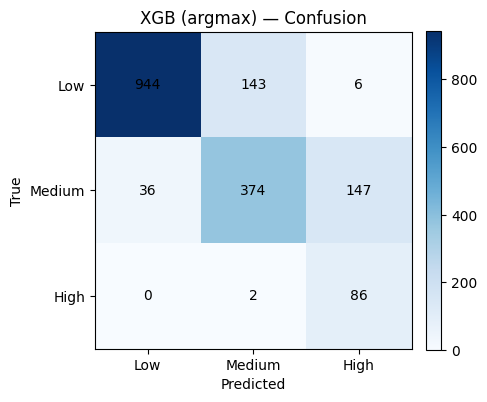

Calibrated class weights on val: (1.15, 0.7, 0.7) → macro-F1: 0.848

=== XGB (calibrated) — Test ===
Accuracy   : 0.8228
Macro-F1   : 0.7191
Weighted-F1: 0.8347

Report:
               precision    recall  f1-score   support

         Low       0.95      0.90      0.93      1093
      Medium       0.77      0.65      0.71       557
        High       0.36      0.98      0.53        88

    accuracy                           0.82      1738
   macro avg       0.69      0.84      0.72      1738
weighted avg       0.87      0.82      0.83      1738



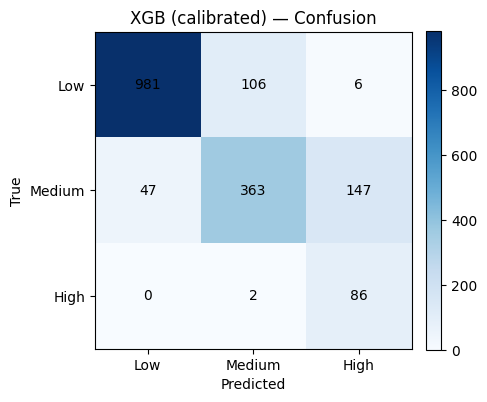

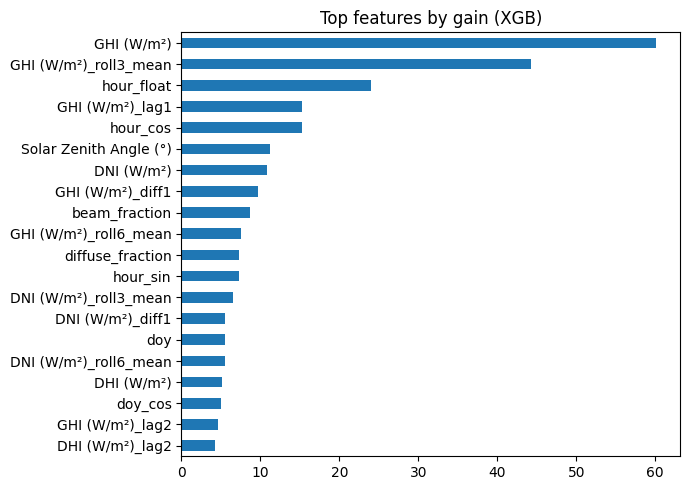

,track,model,label_mode,cv_macro_f1,val_macro_f1_cal,test_acc_argmax,test_macro_f1_argmax,test_weighted_f1_argmax,test_acc_cal,test_macro_f1_cal,...,fit_time_sec,pred_time_sec,acc_argmax,macroF1_argmax,weightedF1_argmax,acc_cal,macroF1_cal,weightedF1_cal,best_iter,best_params
0,classification,XGBClassifier,fixed,0.799193,0.862905,0.821059,0.720551,0.833079,0.842348,0.752343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,XGBClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.975,0.015,0.8078,0.7106,0.8222,0.8228,0.7191,0.8347,239.0,"{""subsample"": 0.95, ""reg_lambda"": 10.0, ""reg_a..."



Saved:
  • xgb_tuning_history.csv
  • model_benchmarks.csv


In [ ]:
# Cell 9 — final training + evaluation + calibration + artifacts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

def report_block(y_true, y_pred, title):
    acc   = accuracy_score(y_true, y_pred)
    f1_ma = f1_score(y_true, y_pred, average="macro")
    f1_wt = f1_score(y_true, y_pred, average="weighted")
    print(f"\n=== {title} ===")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Macro-F1   : {f1_ma:.4f}")
    print(f"Weighted-F1: {f1_wt:.4f}")
    print("\nReport:\n", classification_report(y_true, y_pred, target_names=["Low","Medium","High"]))
    return {"accuracy":acc, "macro_f1":f1_ma, "weighted_f1":f1_wt}

def plot_confmat(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    fig, ax = plt.subplots(figsize=(4.8,4.2))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
    ax.set_xticklabels(["Low","Medium","High"])
    ax.set_yticklabels(["Low","Medium","High"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

def apply_calibration(P, alpha=(1.0,1.0,1.0)):
    P = P * np.asarray(alpha)[None, :]
    P = P / P.sum(axis=1, keepdims=True)
    return P

# split tail of train as validation (time-safe)
cut = int(0.9 * len(Xtr_df))
Xtr_in, ytr_in = Xtr_df.iloc[:cut], y_train[:cut]
Xva_in, yva_in = Xtr_df.iloc[cut:], y_train[cut:]
w_tr_in = np.vectorize(cls_w.get)(ytr_in)

final = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    tree_method="hist",
    eval_metric="mlogloss",
    n_estimators=3000,
    random_state=42,
    n_jobs=-1,
    **best_params
)

start = time.time()
final_fitted = _fit_with_es(final, Xtr_in, ytr_in, w_tr_in, Xva_in, yva_in, es_rounds=max(50, best_rounds))
t_fit = time.time() - start
best_iter = getattr(final_fitted, "best_iteration_", None)
print("Best iteration (final):", best_iter)

# learning curve (if available)
ev = {}
try:
    ev = final_fitted.evals_result()
except Exception:
    pass

if ev and "validation_0" in ev:
    plt.figure(figsize=(6,3.5))
    plt.plot(ev["validation_0"]["mlogloss"], label="val_logloss")
    if "train" in ev:
        plt.plot(ev["train"]["mlogloss"], label="train_logloss", alpha=0.7)
    plt.xlabel("trees"); plt.ylabel("logloss"); plt.title("XGB — learning curve"); plt.legend()
    plt.tight_layout(); plt.show()

# predict on test
t0 = time.time()
proba_test = final_fitted.predict_proba(Xte_df)
pred_argmax = proba_test.argmax(axis=1)
t_pred = time.time() - t0

scores_arg = report_block(y_test, pred_argmax, "XGB (prob-argmax) — Test")
plot_confmat(y_test, pred_argmax, "XGB (argmax) — Confusion")

# tiny probability calibration on validation tail (per-class multipliers)
proba_val = final_fitted.predict_proba(Xva_in)
grid = [0.7, 0.85, 1.0, 1.15, 1.3]
best_alpha, best_f1 = (1.0,1.0,1.0), -1.0
for a0 in grid:
    for a1 in grid:
        for a2 in grid:
            Pv = apply_calibration(proba_val, (a0,a1,a2))
            f1v = f1_score(yva_in, Pv.argmax(axis=1), average="macro")
            if f1v > best_f1:
                best_f1, best_alpha = f1v, (a0,a1,a2)

print(f"Calibrated class weights on val: {best_alpha} → macro-F1: {best_f1:.3f}")
pred_cal = apply_calibration(proba_test, best_alpha).argmax(axis=1)
scores_cal = report_block(y_test, pred_cal, "XGB (calibrated) — Test")
plot_confmat(y_test, pred_cal, "XGB (calibrated) — Confusion")

# feature importance (gain)
booster = final_fitted.get_booster()
gain_raw = booster.get_score(importance_type="gain")
name_map = {f"f{i}": c for i, c in enumerate(X_cols)}
gain = pd.Series({name_map.get(k, k): v for k, v in gain_raw.items()})
if not gain.empty:
    top = gain.sort_values(ascending=False).head(20)
    plt.figure(figsize=(7,5))
    top.sort_values().plot.barh()
    plt.title("Top features by gain (XGB)")
    plt.tight_layout(); plt.show()

# benchmarks table
row = {
    "model": "XGBClassifier",
    "train_rows": len(X_train),
    "test_rows": len(X_test),
    "fit_time_sec": round(t_fit, 3),
    "pred_time_sec": round(t_pred, 3),
    "acc_argmax": round(scores_arg["accuracy"], 4),
    "macroF1_argmax": round(scores_arg["macro_f1"], 4),
    "weightedF1_argmax": round(scores_arg["weighted_f1"], 4),
    "acc_cal": round(scores_cal["accuracy"], 4),
    "macroF1_cal": round(scores_cal["macro_f1"], 4),
    "weightedF1_cal": round(scores_cal["weighted_f1"], 4),
    "best_iter": int(best_iter) if best_iter is not None else None,
    "best_params": json.dumps({k: (float(v) if isinstance(v, np.generic) else v) for k,v in (best_params or {}).items()}),
}
try:
    prev = pd.read_csv("model_benchmarks.csv")
    bench = pd.concat([prev, pd.DataFrame([row])], ignore_index=True)
except Exception:
    bench = pd.DataFrame([row])
bench.to_csv("model_benchmarks.csv", index=False)
display(bench.tail(3))

print("\nSaved:")
print("  • xgb_tuning_history.csv")
print("  • model_benchmarks.csv")


## Model 3:

Using 48 features: ['GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)', 'Temp (°C)', 'RH (%)', 'Pressure (hPa)', 'Wind Speed (m/s)', 'Wind Direction (°)', 'Solar Zenith Angle (°)', 'hour_float'] ...
Rows: total=8689, train=6951, test=1738
Seq shapes — train: (6904, 48, 48), test: (1691, 48, 48)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 48, 128)        │        68,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,825 (429.00 KB)

 Trainable params: 109,825 (429.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - loss: 122225.8125 - rmse: 341.4463 - val_loss: 166200.4688 - val_rmse: 407.6769 - learning_rate: 0.0010
Epoch 2/60
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - loss: 90585.5469 - rmse: 292.6757 - val_loss: 115174.3125 - val_rmse: 339.3734 - learning_rate: 0.0010
Epoch 3/60
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - loss: 63715.3633 - rmse: 245.5493 - val_loss: 86644.2266 - val_rmse: 294.3539 - learning_rate: 0.0010
Epoch 4/60
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - loss: 60525.2969 - rmse: 243.3300 - val_loss: 80599.3594 - val_rmse: 283.9003 - learning_rate: 0.0010
Epoch 5/60
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - loss: 66641.2109 - rmse: 257.1733 - val_loss: 80187.0391 - val_rmse: 283.1732 - learning_rate: 0.0010
Epoch 6/60
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - loss: 69356.7344 - rmse: 262.7062 - val_loss: 80233.5156 - val_rmse: 283.2552 - learning_rate: 0.0010
Epoch 7/60
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - 

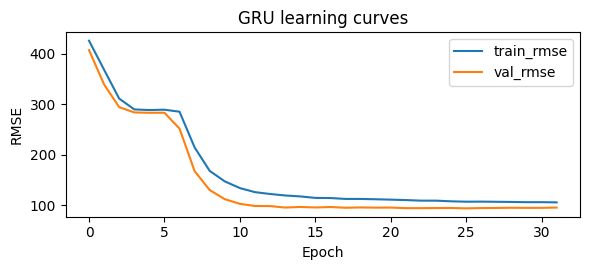

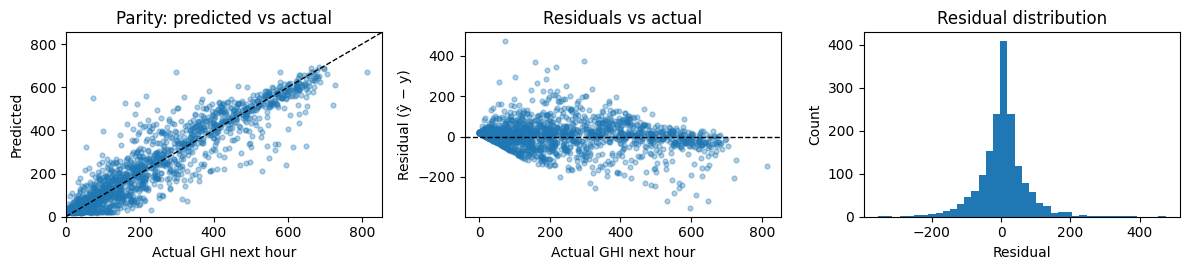


=== Binned confusion matrix (GRU predictions) ===
[[982  89   0]
 [ 66 463  10]
 [  0  32  49]]

=== Classification report (binned) ===
              precision    recall  f1-score   support

         Low     0.9370    0.9169    0.9269      1071
      Medium     0.7928    0.8590    0.8246       539
        High     0.8305    0.6049    0.7000        81

    accuracy                         0.8835      1691
   macro avg     0.8534    0.7936    0.8171      1691
weighted avg     0.8860    0.8835    0.8834      1691



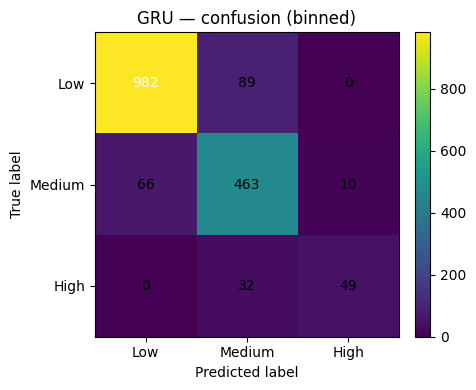


Saved:
  • /content/gru_predictions_test.csv
  • /content/gru_train_history.csv
  • /content/model_benchmarks.csv (appended)


In [ ]:
# =========================
# Model 3 — GRU Regressor
# Next-hour GHI (W/m²) from a rolling window of features
# =========================

import os, time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# -------- settings --------
FEATURES_CSV = "/content/solar_data_2024_30min_features.csv"  # produced in earlier cells
TARGET_COL   = "Target_GHI_NextHour (W/m²)"
LOOKBACK     = 48        # 24h context at 30-min step
BATCH_SIZE   = 64
EPOCHS       = 60
VAL_SPLIT    = 0.2       # last 20% of train used for validation (no shuffling)

# fixed classification bins for the "binned" view
BINS   = np.array([0.0, 250.0, 600.0, np.inf], dtype=float)
LABELS = ['Low', 'Medium', 'High']

np.random.seed(42)
tf.random.set_seed(42)

# -------- helpers --------
def rmse_np(y_true, y_pred):
    y_true = np.asarray(y_true, float).ravel()
    y_pred = np.asarray(y_pred, float).ravel()
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

def mae_np(y_true, y_pred):
    y_true = np.asarray(y_true, float).ravel()
    y_pred = np.asarray(y_pred, float).ravel()
    return float(np.mean(np.abs(y_pred - y_true)))

def r2_np(y_true, y_pred):
    y_true = np.asarray(y_true, float).ravel()
    y_pred = np.asarray(y_pred, float).ravel()
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return float(1.0 - ss_res / ss_tot) if ss_tot > 0 else np.nan

def smape_np(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true, float).ravel()
    y_pred = np.asarray(y_pred, float).ravel()
    return float(np.mean(2.0 * np.abs(y_pred - y_true) /
                         (np.abs(y_true) + np.abs(y_pred) + eps)) * 100.0)

def make_sequences(X2d, y1d, L):
    """Turn [T, F] into [T-L+1, L, F] with target aligned to the last step in each window."""
    X_seq, y_seq = [], []
    for i in range(L - 1, len(X2d)):
        X_seq.append(X2d[i - L + 1:i + 1, :])
        y_seq.append(y1d[i])
    return np.asarray(X_seq, np.float32), np.asarray(y_seq, np.float32)

# -------- load features + split (time-safe) --------
df = pd.read_csv(FEATURES_CSV, parse_dates=["Timestamp"])
df = df.sort_values("Timestamp").reset_index(drop=True)

# keep numeric columns; remove target from features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
assert TARGET_COL in num_cols, f"Missing target '{TARGET_COL}'"
feat_cols = [c for c in num_cols if c != TARGET_COL]

X_all = df[feat_cols].to_numpy(np.float32)
y_all = df[TARGET_COL].to_numpy(np.float32)

split_idx = int(len(df) * 0.8)
X_tr, X_te = X_all[:split_idx], X_all[split_idx:]
y_tr, y_te = y_all[:split_idx], y_all[split_idx:]

# scale using only training data
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr).astype(np.float32)
X_te = scaler.transform(X_te).astype(np.float32)

# sequences (built separately to avoid leakage)
Xtr_seq, ytr_seq = make_sequences(X_tr, y_tr, LOOKBACK)
Xte_seq, yte_seq = make_sequences(X_te, y_te, LOOKBACK)

n_features = Xtr_seq.shape[-1]
print(f"Using {n_features} features: {feat_cols[:10]} ...")
print(f"Rows: total={len(df)}, train={split_idx}, test={len(df)-split_idx}")
print(f"Seq shapes — train: {Xtr_seq.shape}, test: {Xte_seq.shape}")

# -------- build GRU model --------
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(LOOKBACK, n_features)),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)
model.summary()

# callbacks: time-safe validation (no shuffle), early stop + LR schedule
cbs = [
    tf.keras.callbacks.EarlyStopping(monitor="val_rmse", patience=6,
                                     restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_rmse", factor=0.5,
                                         patience=3, min_lr=1e-5, verbose=1),
]

t0 = time.time()
hist = model.fit(
    Xtr_seq, ytr_seq,
    validation_split=VAL_SPLIT,  # tail of the training set
    shuffle=False,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=cbs
)
train_time = time.time() - t0

# best epoch for reference
val_rmse_hist = hist.history.get("val_rmse", [])
best_epoch = int(np.argmin(val_rmse_hist)) + 1 if val_rmse_hist else None
if best_epoch:
    print(f"Best epoch (by val_rmse): {best_epoch} / {len(val_rmse_hist)} | train_time: {train_time:.1f}s")

# -------- evaluate on test --------
y_hat = model.predict(Xte_seq, verbose=0).ravel()

rmse = rmse_np(yte_seq, y_hat)
mae  = mae_np(yte_seq, y_hat)
r2   = r2_np(yte_seq, y_hat)
smape = smape_np(yte_seq, y_hat)

# persistence baseline: "next hour ≈ current hour GHI"
# align baseline to the sequenced test indices
ghi_test = X_te[:, feat_cols.index("GHI (W/m²)")]
y_persist = ghi_test[LOOKBACK - 1:]
rmse_persist = rmse_np(yte_seq, y_persist)

print(f"\n=== GRU Regressor — Test ===")
print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | sMAPE: {smape:.2f}% | R²: {r2:.3f}")
improve = (1.0 - rmse / rmse_persist) * 100.0
print(f"vs Persistence: RMSE improved by {improve:.1f}% (baseline RMSE={rmse_persist:.2f})")

# -------- plots: learning curves --------
train_rmse = hist.history.get("rmse", [])
val_rmse   = hist.history.get("val_rmse", [])

plt.figure(figsize=(6,2.8))
plt.plot(train_rmse, label="train_rmse")
plt.plot(val_rmse, label="val_rmse")
plt.xlabel("Epoch"); plt.ylabel("RMSE"); plt.title("GRU learning curves")
plt.legend(); plt.tight_layout(); plt.show()

# -------- plots: parity + residuals --------
fig, axes = plt.subplots(1, 3, figsize=(12, 2.8))
# Parity
axes[0].scatter(yte_seq, y_hat, s=12, alpha=0.35)
lim = [0, max(yte_seq.max(), y_hat.max())*1.05]
axes[0].plot(lim, lim, 'k--', lw=1)
axes[0].set_title("Parity: predicted vs actual")
axes[0].set_xlabel("Actual GHI next hour"); axes[0].set_ylabel("Predicted")
axes[0].set_xlim(lim); axes[0].set_ylim(lim)

# Residuals vs actual
res = y_hat - yte_seq
axes[1].scatter(yte_seq, res, s=12, alpha=0.35)
axes[1].axhline(0, color='k', ls='--', lw=1)
axes[1].set_title("Residuals vs actual")
axes[1].set_xlabel("Actual GHI next hour"); axes[1].set_ylabel("Residual (ŷ − y)")

# Residual histogram
axes[2].hist(res, bins=40)
axes[2].set_title("Residual distribution")
axes[2].set_xlabel("Residual"); axes[2].set_ylabel("Count")
plt.tight_layout(); plt.show()

# -------- robust binned confusion matrix on regression outputs --------
# clean + clip predictions to ensure they fit in bins
mask = np.isfinite(yte_seq) & np.isfinite(y_hat)
y_true = np.clip(yte_seq[mask], 0.0, None)
y_pred = np.clip(y_hat[mask],   0.0, None)

y_true_cat = pd.cut(y_true, bins=BINS, labels=LABELS, include_lowest=True, right=False)
y_pred_cat = pd.cut(y_pred, bins=BINS, labels=LABELS, include_lowest=True, right=False)

ok = (~pd.isna(y_true_cat)) & (~pd.isna(y_pred_cat))
y_true_cat = y_true_cat[ok]; y_pred_cat = y_pred_cat[ok]

lab2id = {'Low':0, 'Medium':1, 'High':2}
y_true_int = np.array([lab2id[s] for s in y_true_cat.astype(str)], dtype=int)
y_pred_int = np.array([lab2id[s] for s in y_pred_cat.astype(str)], dtype=int)

cm = confusion_matrix(y_true_int, y_pred_int, labels=[0,1,2])
print("\n=== Binned confusion matrix (GRU predictions) ===")
print(cm)
print("\n=== Classification report (binned) ===")
print(classification_report(y_true_int, y_pred_int, target_names=LABELS, digits=4))

# plot confusion
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap='viridis')
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
ax.set_xticklabels(LABELS); ax.set_yticklabels(LABELS)
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("GRU — confusion (binned)")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center',
                color='white' if cm[i,j] > cm.max()*0.6 else 'black')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# -------- save artifacts + benchmark row --------
pred_path   = "/content/gru_predictions_test.csv"
hist_path   = "/content/gru_train_history.csv"
bench_path  = "/content/model_benchmarks.csv"

pd.DataFrame({"y_true": yte_seq, "y_pred": y_hat}).to_csv(pred_path, index=False)
pd.DataFrame(hist.history).to_csv(hist_path, index=False)

row = {
    "track": "regression",
    "model": "GRU(seq2one)",
    "lookback": LOOKBACK,
    "test_rmse": rmse, "test_mae": mae, "test_smape": smape, "test_r2": r2,
    "baseline_rmse": rmse_persist, "rmse_improvement_pct": improve,
    "epochs_trained": len(train_rmse), "best_epoch": best_epoch,
    "fit_time_sec": train_time
}
# append to CSV (create if missing)
if os.path.exists(bench_path):
    bench = pd.read_csv(bench_path)
    bench = pd.concat([bench, pd.DataFrame([row])], ignore_index=True)
else:
    bench = pd.DataFrame([row])
bench.to_csv(bench_path, index=False)

print("\nSaved:")
print(f"  • {pred_path}")
print(f"  • {hist_path}")
print(f"  • {bench_path} (appended)")


## Model 4: DL Classifier — Temporal Convolutional Network (TCN)

Sequence shapes — train: (6232, 24, 48), val: (671, 24, 48), test: (1714, 24, 48)
Using 48 features: ['GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)', 'Temp (°C)', 'RH (%)', 'Pressure (hPa)', 'Wind Speed (m/s)', 'Wind Direction (°)', 'Solar Zenith Angle (°)', 'hour_float'] ...
Class weights (train): {0: 0.7029892836999436, 1: 1.1464311994113319, 2: 1.4179749715585892}

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 15.

=== LSTM baseline ===
Accuracy : 0.7001 | Macro-F1: 0.5923 | Weighted-F1: 0.7285
              precision    recall  f1-score   support

         Low       0.95      0.78      0.86      1086
      Medium       0.55      0.50      0.52       547
        High       0.25      1.00      0.40        81

    accuracy                           0.70      1714
   macro avg       0.58      0.76      0.59      1714
weighted avg 

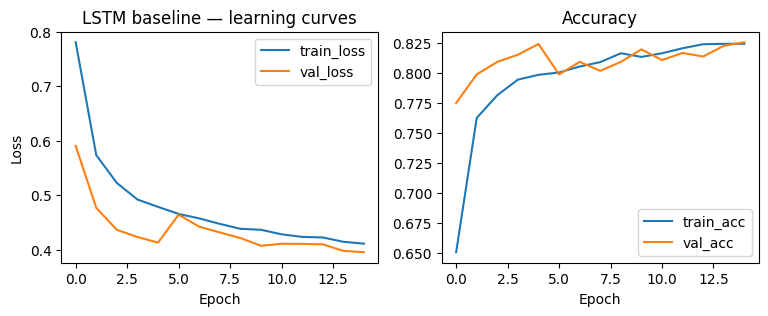

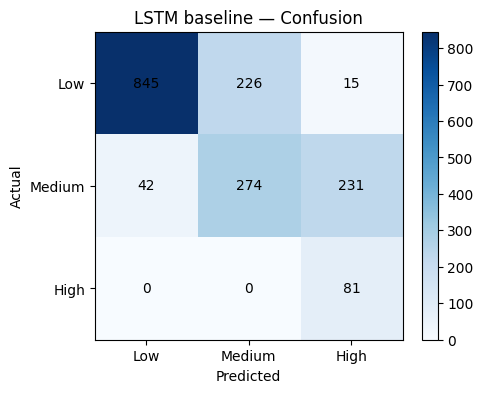

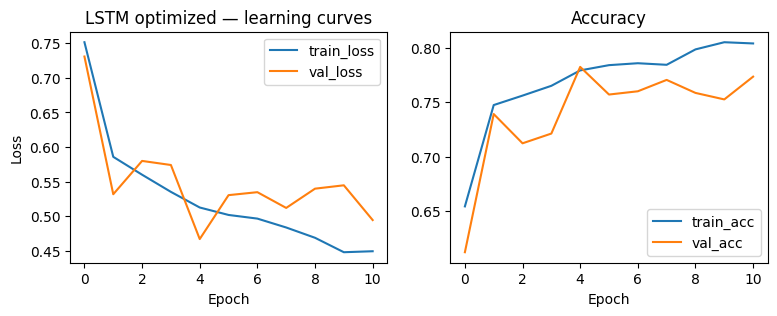

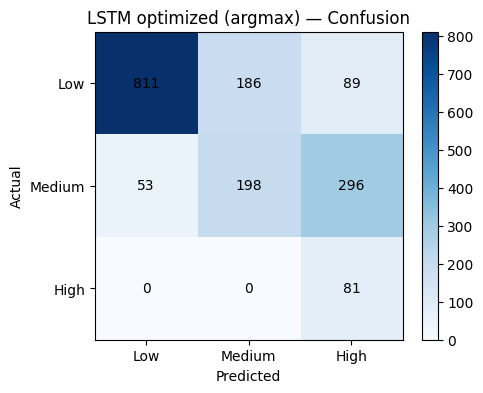

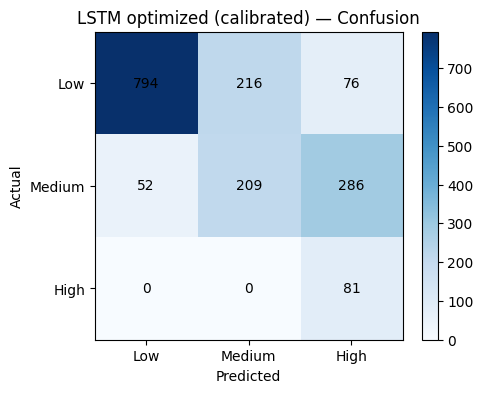

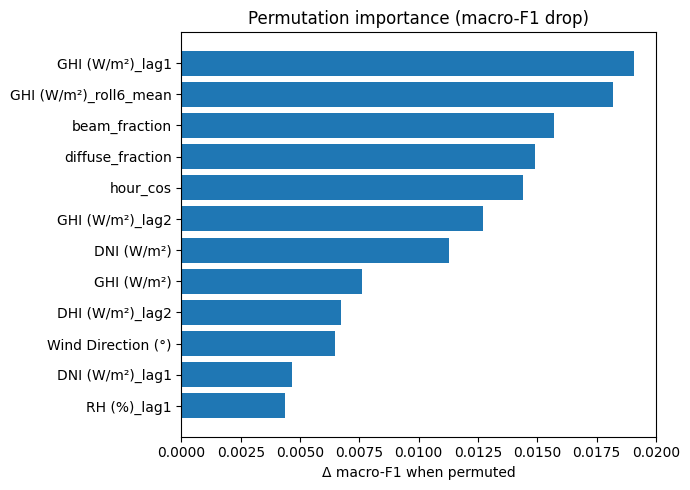


Saved:
 • /content/lstm_predictions_test.csv
 • /content/lstm_train_history.csv
 • /content/model_benchmarks.csv


In [23]:
# Model 4 — Pure LSTM Classifier (uses the same split as Cell 6)
# --------------------------------------------------------------
# What this cell does:
# 1) Load feature CSV and create class labels from the next-hour GHI target
# 2) Reproduce Cell 6’s time-safe split (train[:6951], test[6951:])
# 3) Scale features on train only; roll into 24-step sequences
# 4) Train a simple "baseline" LSTM
# 5) Train an "optimized" LSTM with better regularisation and depth
# 6) Calibrate class probabilities on a validation slice for a macro-F1 bump
# 7) Plot learning curves, confusion matrices, and permutation importance
# 8) Append a row to model_benchmarks.csv

import os, time, json, math, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models

# -----------------------------
# 0) Load features, make labels
# -----------------------------
FEAT_CSV = "/content/solar_data_2024_30min_features.csv"   # produced earlier
df = pd.read_csv(FEAT_CSV, parse_dates=["Timestamp"]).sort_values("Timestamp").reset_index(drop=True)

# Categorical
bins   = [0, 250, 600, np.inf]
labels = ["Low", "Medium", "High"]
y_cat  = pd.Categorical(pd.cut(y_reg, bins=bins, labels=labels, include_lowest=True))
y_all  = y_cat.codes.astype(np.int32)      # 0=Low, 1=Medium, 2=High



# Feature list: everything numeric except the target / label helpers
drop_cols = {"Timestamp","Target_GHI_NextHour (W/m²)","ghi_category"}
feature_cols = [c for c in df.columns if c not in drop_cols and df[c].dtype != "O"]
X_all = df[feature_cols].to_numpy(np.float32)

# -------------------------------------------------
# 1) Reproduce Cell 6 split (time-safe, split_idx=6951)
# -------------------------------------------------
split_idx = 6951  # same as Cell 6
X_tr_full, X_te = X_all[:split_idx], X_all[split_idx:]
y_tr_full, y_te = y_all[:split_idx], y_all[split_idx:]

# make a small validation slice from the END of the training period (time-safe)
val_len = max(256, int(0.10 * len(X_tr_full)))  # ~10% of train
X_tr, X_va = X_tr_full[:-val_len], X_tr_full[-val_len:]
y_tr, y_va = y_tr_full[:-val_len], y_tr_full[-val_len:]

# scale by train-only statistics
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr); X_va = scaler.transform(X_va); X_te = scaler.transform(X_te)

# ---------------------------------------
# 2) Turn rows into sequences (lookback=24)
# ---------------------------------------
LOOKBACK = 24
def to_sequences(X, y, lb=LOOKBACK, stride=1):
    xs, ys = [], []
    for i in range(lb, len(X), stride):
        xs.append(X[i-lb:i])
        ys.append(y[i])
    return np.asarray(xs, np.float32), np.asarray(ys, np.int32)

Xtr_seq, ytr_seq = to_sequences(X_tr, y_tr, lb=LOOKBACK)
Xva_seq, yva_seq = to_sequences(X_va, y_va, lb=LOOKBACK)
Xte_seq, yte_seq = to_sequences(X_te, y_te, lb=LOOKBACK)

print(f"Sequence shapes — train: {Xtr_seq.shape}, val: {Xva_seq.shape}, test: {Xte_seq.shape}")
print("Using", len(feature_cols), "features:", feature_cols[:10], "...")

# --------------------------------------
# 3) Class weights to mitigate imbalance
# --------------------------------------
classes = np.array([0,1,2])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=ytr_seq)
class_weights = {int(c): float(w) for c,w in zip(classes, cw)}
print("Class weights (train):", class_weights)

# --------------------------------------
# 4) Model builders: baseline vs optimized
# --------------------------------------
def build_lstm_baseline(input_shape, n_classes=3):
    """Small single-LSTM as a baseline."""
    inp = layers.Input(shape=input_shape)
    x = layers.LSTM(64, dropout=0.2, recurrent_dropout=0.0)(inp)
    out = layers.Dense(n_classes, activation="softmax")(x)
    model = models.Model(inp, out, name="LSTM_baseline")
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def build_lstm_optimized(input_shape, n_classes=3):
    """
    Deeper/better-regularised LSTM:
    - LayerNorm + SpatialDropout1D
    - Two LSTM blocks (128 -> 64) with return_sequences on the first
    - Gradient clipping for stability
    """
    inp = layers.Input(shape=input_shape)
    x = layers.LayerNormalization()(inp)
    x = layers.SpatialDropout1D(0.15)(x)

    x = layers.LSTM(128, return_sequences=True, dropout=0.25, recurrent_dropout=0.0)(x)
    x = layers.LSTM(64, dropout=0.25, recurrent_dropout=0.0)(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.25)(x)
    out = layers.Dense(n_classes, activation="softmax")(x)

    model = models.Model(inp, out, name="LSTM_optimized")
    opt = tf.keras.optimizers.Adam(learning_rate=2e-3, clipnorm=1.0)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# --------------------------------------
# 5) Training helpers / callbacks
# --------------------------------------
BATCH = 128
EPOCHS_BASE = 15
EPOCHS_OPT  = 30

cb_common = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                         patience=3, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6,
                                     restore_best_weights=True, verbose=1)
]

# --------------------------
# 6) Train the BASELINE LSTM
# --------------------------
baseline = build_lstm_baseline(Xtr_seq.shape[1:])
t0 = time.time()
hist_base = baseline.fit(
    Xtr_seq, ytr_seq,
    validation_data=(Xva_seq, yva_seq),
    epochs=EPOCHS_BASE, batch_size=BATCH,
    class_weight=class_weights, verbose=0, callbacks=cb_common
)
base_train_time = time.time() - t0

# Evaluate on test (argmax)
proba_base = baseline.predict(Xte_seq, batch_size=BATCH, verbose=0)
pred_base  = proba_base.argmax(axis=1)
acc_b  = accuracy_score(yte_seq, pred_base)
mf1_b  = f1_score(yte_seq, pred_base, average="macro")
wf1_b  = f1_score(yte_seq, pred_base, average="weighted")
print("\n=== LSTM baseline ===")
print(f"Accuracy : {acc_b:.4f} | Macro-F1: {mf1_b:.4f} | Weighted-F1: {wf1_b:.4f}")
print(classification_report(yte_seq, pred_base, target_names=labels))

# ----------------------------
# 7) Train the OPTIMIZED LSTM
# ----------------------------
optm = build_lstm_optimized(Xtr_seq.shape[1:])
t1 = time.time()
hist_opt = optm.fit(
    Xtr_seq, ytr_seq,
    validation_data=(Xva_seq, yva_seq),
    epochs=EPOCHS_OPT, batch_size=BATCH,
    class_weight=class_weights, verbose=0, callbacks=cb_common
)
opt_train_time = time.time() - t1

# Argmax evaluation
proba_opt = optm.predict(Xte_seq, batch_size=BATCH, verbose=0)
pred_opt  = proba_opt.argmax(axis=1)
acc_o  = accuracy_score(yte_seq, pred_opt)
mf1_o  = f1_score(yte_seq, pred_opt, average="macro")
wf1_o  = f1_score(yte_seq, pred_opt, average="weighted")
print("\n=== LSTM optimized (argmax) ===")
print(f"Accuracy : {acc_o:.4f} | Macro-F1: {mf1_o:.4f} | Weighted-F1: {wf1_o:.4f}")
print(classification_report(yte_seq, pred_opt, target_names=labels))

# ---------------------------------------------------------
# 8) Simple probability calibration on the validation split
# ---------------------------------------------------------
def best_calibration_weights(model, Xv, yv, grid=((1,1,1),(1.1,1,0.9),(1,1.1,0.9),(1,1.2,0.8),(0.9,1.1,1.1),(1,0.9,1.1))):
    pv = model.predict(Xv, batch_size=BATCH, verbose=0)
    best = (-1, (1,1,1))
    for w in grid:
        w = np.asarray(w, np.float32)
        pv_w = pv * w
        pv_w = pv_w / pv_w.sum(axis=1, keepdims=True)
        yhat = pv_w.argmax(axis=1)
        f1 = f1_score(yv, yhat, average="macro")
        if f1 > best[0]:
            best = (f1, tuple(map(float, w)))
    return best

cal_score, cal_w = best_calibration_weights(optm, Xva_seq, yva_seq)
print("\nCalibration weights (val macro-F1):", cal_w, "→", f"{cal_score:.4f}")

# Apply calibration to test
proba_cal = proba_opt * np.asarray(cal_w, np.float32)
proba_cal = proba_cal / proba_cal.sum(axis=1, keepdims=True)
pred_cal  = proba_cal.argmax(axis=1)
acc_c  = accuracy_score(yte_seq, pred_cal)
mf1_c  = f1_score(yte_seq, pred_cal, average="macro")
wf1_c  = f1_score(yte_seq, pred_cal, average="weighted")
print("\n=== LSTM optimized (calibrated) ===")
print(f"Accuracy : {acc_c:.4f} | Macro-F1: {mf1_c:.4f} | Weighted-F1: {wf1_c:.4f}")
print(classification_report(yte_seq, pred_cal, target_names=labels))

# ----------------------------
# 9) Plots — learning & confusion
# ----------------------------
def plot_learning(history, title):
    h = history.history
    fig, ax = plt.subplots(1,2, figsize=(9,3))
    ax[0].plot(h["loss"], label="train_loss"); ax[0].plot(h["val_loss"], label="val_loss")
    ax[0].set_title(f"{title} — learning curves"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss"); ax[0].legend()
    if "accuracy" in h:
        ax[1].plot(h["accuracy"], label="train_acc"); ax[1].plot(h["val_accuracy"], label="val_acc")
        ax[1].set_title("Accuracy"); ax[1].set_xlabel("Epoch"); ax[1].legend(loc="lower right")
    plt.show()

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, cmap="Blues")
    for (i,j),v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha='center', va='center')
    ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual"); ax.set_title(title)
    fig.colorbar(im, ax=ax); plt.show()

plot_learning(hist_base, "LSTM baseline")
plot_cm(yte_seq, pred_base, "LSTM baseline — Confusion")

plot_learning(hist_opt, "LSTM optimized")
plot_cm(yte_seq, pred_opt, "LSTM optimized (argmax) — Confusion")
plot_cm(yte_seq, pred_cal, "LSTM optimized (calibrated) — Confusion")

# -----------------------------------------------------------
# 10) Lightweight permutation importance (macro-F1 drop, val)
# -----------------------------------------------------------
# We permute one feature across the validation set (same shuffle for all timesteps),
# predict, and see how macro-F1 drops. This is *approximate* but useful.
def permutation_importance_seq(model, X_seq, y_seq, feat_names, repeats=2):
    rng = np.random.default_rng(42)
    base_pred = model.predict(X_seq, batch_size=BATCH, verbose=0).argmax(axis=1)
    base_f1 = f1_score(y_seq, base_pred, average="macro")
    drops = []
    for j, name in enumerate(feat_names):
        f1_sum = 0.0
        for _ in range(repeats):
            Xp = X_seq.copy()
            # shuffle the feature across sequences (same permutation for all timesteps)
            idx = rng.permutation(len(Xp))
            Xp[:, :, j] = Xp[idx, :, j]
            yhat = model.predict(Xp, batch_size=BATCH, verbose=0).argmax(axis=1)
            f1_sum += f1_score(y_seq, yhat, average="macro")
        drops.append((name, float(base_f1 - f1_sum / repeats)))
    drops.sort(key=lambda x: x[1], reverse=True)
    return drops

top_imp = permutation_importance_seq(optm, Xva_seq, yva_seq, feature_cols, repeats=2)[:12]
plt.figure(figsize=(7,5))
plt.barh([n for n,_ in reversed(top_imp)], [d for _,d in reversed(top_imp)])
plt.title("Permutation importance (macro-F1 drop)"); plt.xlabel("Δ macro-F1 when permuted"); plt.tight_layout(); plt.show()

# ----------------------------------------
# 11) Save predictions / history / benchmark
# ----------------------------------------
pred_df = pd.DataFrame({
    "Timestamp": df.loc[split_idx+LOOKBACK:split_idx+LOOKBACK+len(yte_seq)-1, "Timestamp"].to_numpy(),
    "y_true": yte_seq,
    "y_pred_argmax": pred_opt,
    "y_pred_calibrated": pred_cal
})
pred_path = "/content/lstm_predictions_test.csv"
pred_df.to_csv(pred_path, index=False)

hist_opt_df = pd.DataFrame(hist_opt.history)
hist_opt_df.to_csv("/content/lstm_train_history.csv", index=False)

bench_path = "/content/model_benchmarks.csv"
bench_row = pd.DataFrame([{
    "track":"classification",
    "model":"LSTMClassifier (baseline/optimized)",
    "label_mode":"fixed",
    "acc_baseline": round(acc_b,4),
    "macroF1_baseline": round(mf1_b,4),
    "weightedF1_baseline": round(wf1_b,4),
    "acc_argmax": round(acc_o,4),
    "macroF1_argmax": round(mf1_o,4),
    "weightedF1_argmax": round(wf1_o,4),
    "acc_cal": round(acc_c,4),
    "macroF1_cal": round(mf1_c,4),
    "weightedF1_cal": round(wf1_c,4),
    "fit_time_baseline_sec": round(base_train_time,1),
    "fit_time_optimized_sec": round(opt_train_time,1),
    "lookback": LOOKBACK,
    "split_idx": split_idx,
    "n_features": len(feature_cols),
    "calibration_weights": json.dumps(cal_w),
}])
if os.path.exists(bench_path):
    pd.concat([pd.read_csv(bench_path), bench_row], ignore_index=True).to_csv(bench_path, index=False)
else:
    bench_row.to_csv(bench_path, index=False)

print("\nSaved:")
print(" •", pred_path)
print(" • /content/lstm_train_history.csv")
print(" •", bench_path)


## Random Forest Classifier (Full Build – From Scratch)

Label mode used: tertile
Class counts (train): {'Low': 2324, 'High': 2324, 'Medium': 2323}
Balancer used: SMOTE-Tomek
Class counts after balancing: {'High': 2156, 'Low': 2147, 'Medium': 1981}
Best RF params: {'n_estimators': 1500, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_samples': None, 'max_features': 0.6, 'max_depth': 16} (search 4143.4s)
Final fit time: 264.5s

RF (Enhanced) — Test  Acc:0.816  Prec:0.793  Rec:0.835  F1:0.807

Per-class report:
              precision    recall  f1-score   support

        High      0.668     0.911     0.771       282
         Low      0.900     0.870     0.885       738
      Medium      0.812     0.723     0.765       716

    accuracy                          0.816      1736
   macro avg      0.793     0.835     0.807      1736
weighted avg      0.826     0.816     0.817      1736



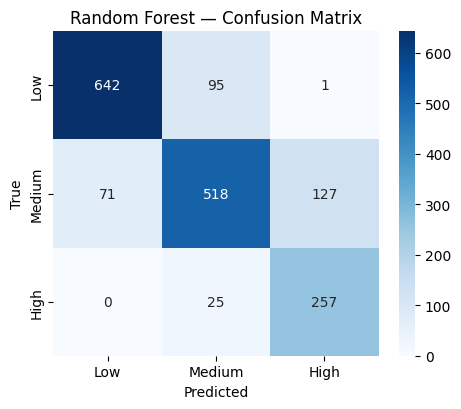

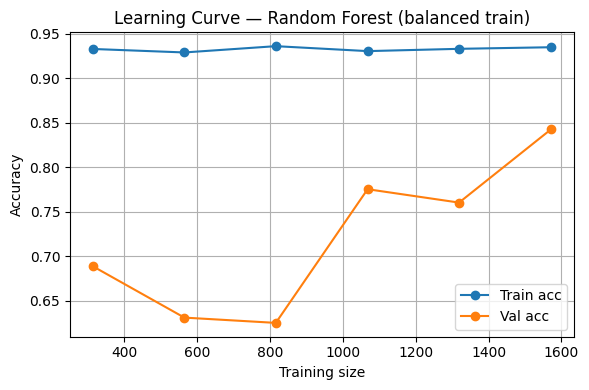

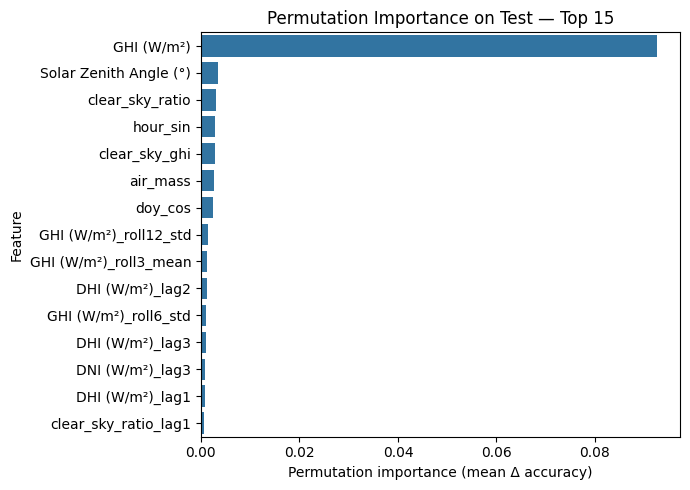

100%|===================| 899/900 [07:13<00:00]       

RF class order: ['High', 'Low', 'Medium']
SHAP summary for class: High


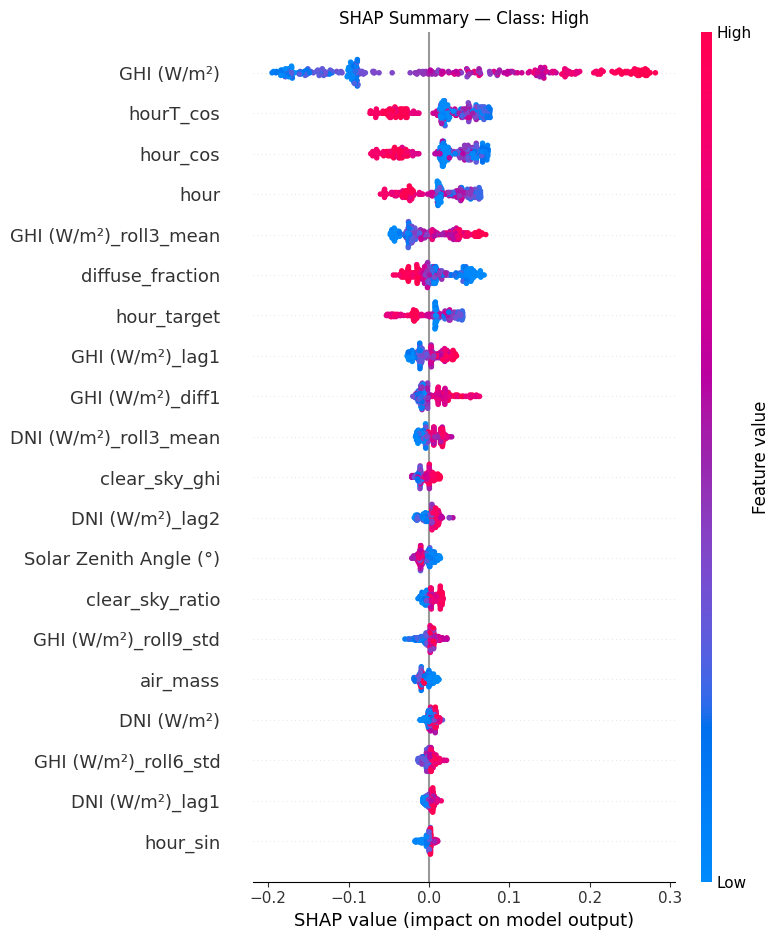

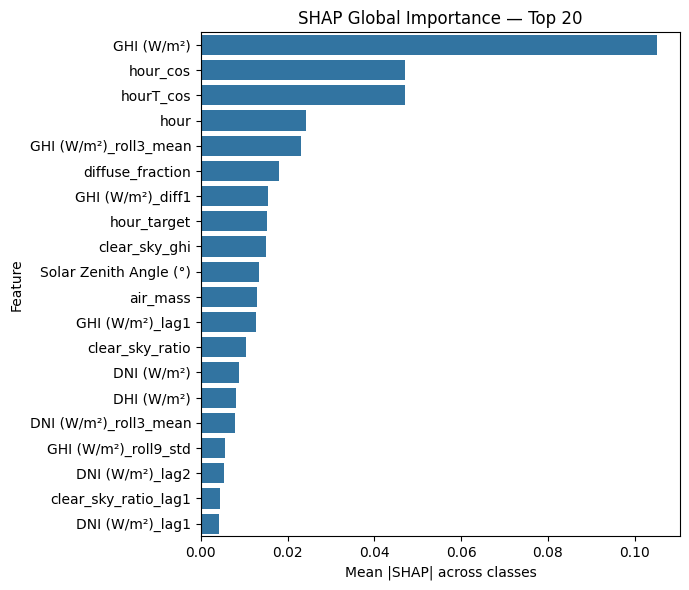

In [ ]:
# # Cell 8 — Random Forest (one cell: richer features + SMOTE-Tomek + TS tuning + diagnostics + SHAP)
# import time, numpy as np, pandas as pd
# import matplotlib.pyplot as plt, seaborn as sns

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, learning_curve, cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
# from sklearn.inspection import permutation_importance

# # imbalance tools
# try:
#     from imblearn.combine import SMOTETomek
#     from imblearn.over_sampling import SMOTE
#     HAS_IMB = True
# except Exception:
#     HAS_IMB = False

# # SHAP
# try:
#     import shap
#     HAS_SHAP = True
# except Exception:
#     HAS_SHAP = False

# # ---------- helpers ----------
# def pick(options, cols):
#     for c in options:
#         if c in cols: return c
#     raise KeyError(f"None of {options} found. Have: {list(cols)}")

# def make_labels_auto(ytr_reg, Xtr_sc, tscv):
#     # compare domain thresholds vs tertiles quickly; pick the better on CV
#     def label_domain(v):
#         if v < 300: return "Low"
#         if v > 700: return "High"
#         return "Medium"
#     q1, q2 = ytr_reg.quantile([1/3, 2/3]).values
#     def label_ter(v):
#         if v <= q1: return "Low"
#         elif v <= q2: return "Medium"
#         else: return "High"

#     y_dom = ytr_reg.apply(label_domain)
#     y_ter = ytr_reg.apply(label_ter)

#     base = RandomForestClassifier(
#         n_estimators=400, max_depth=12, min_samples_leaf=12,
#         class_weight='balanced_subsample', n_jobs=-1, random_state=42
#     )
#     s_dom = cross_val_score(base, Xtr_sc, y_dom, cv=tscv, scoring='accuracy', n_jobs=-1).mean()
#     s_ter = cross_val_score(base, Xtr_sc, y_ter, cv=tscv, scoring='accuracy', n_jobs=-1).mean()
#     return (y_dom, 'domain') if s_dom >= s_ter else (y_ter, 'tertile'), (label_domain if s_dom>=s_ter else label_ter)

# # ---------- 1) copy + detect column names ----------
# df_ext = df_feat.copy()
# ghi_col  = pick(['ghi_w_m2','GHI (W/m²)'], df_ext.columns)
# temp_col = pick(['temp_c','Temp (°C)'], df_ext.columns)

# # ---------- 2) add extra lags/rollings ----------
# for lag in [1,2,3,4]:
#     df_ext[f'{ghi_col}_lag{lag}']  = df_ext[ghi_col].shift(lag)
#     df_ext[f'{temp_col}_lag{lag}'] = df_ext[temp_col].shift(lag)
# for win in [3,6,9,12]:
#     df_ext[f'{ghi_col}_roll{win}_mean'] = df_ext[ghi_col].rolling(win).mean()
#     df_ext[f'{ghi_col}_roll{win}_std']  = df_ext[ghi_col].rolling(win).std()

# # ---------- 3) daylight mask with index intersection ----------
# DAYLIGHT_ONLY = True
# if DAYLIGHT_ONLY and ('is_daylight' in df_ext.columns):
#     daylight_idx = df_ext.index[df_ext['is_daylight']==1]
# else:
#     daylight_idx = df_ext.index

# tr_idx = X_train.index.intersection(daylight_idx)
# te_idx = X_test.index.intersection(daylight_idx)

# Xtr_raw = df_ext.loc[tr_idx].copy().dropna()
# Xte_raw = df_ext.loc[te_idx].copy().dropna()

# ytr_reg = y_reg_train.loc[Xtr_raw.index]
# yte_reg = y_reg_test.loc[Xte_raw.index]

# # ---------- 4) build labels (auto choose) ----------
# non_feats = {'timestamp','Timestamp','ghi_category','Target_GHI_NextHour (W/m²)','target_ghi_nexthour_w_m2'}
# feat_cols = [c for c in Xtr_raw.columns if c not in non_feats]
# Xtr = Xtr_raw[feat_cols];  Xte = Xte_raw[feat_cols]

# scaler = StandardScaler()
# Xtr_sc = pd.DataFrame(scaler.fit_transform(Xtr), index=Xtr.index, columns=Xtr.columns)
# Xte_sc = pd.DataFrame(scaler.transform(Xte),    index=Xte.index, columns=Xte.columns)

# tscv_small = TimeSeriesSplit(n_splits=3)
# ((ytr_labels, label_mode), f_test_rule) = make_labels_auto(ytr_reg, Xtr_sc, tscv_small)
# yte_labels = yte_reg.apply(f_test_rule)
# print(f"Label mode used: {label_mode}")
# print("Class counts (train):", ytr_labels.value_counts().to_dict())

# # ---------- 5) balance train set (use DataFrame to preserve names) ----------
# if HAS_IMB:
#     try:
#         bal = SMOTETomek(random_state=42)
#         X_bal_np, y_bal = bal.fit_resample(Xtr_sc.values, ytr_labels.values)
#         balancer_name = "SMOTE-Tomek"
#     except Exception:
#         bal = SMOTE(random_state=42, k_neighbors=5)
#         X_bal_np, y_bal = bal.fit_resample(Xtr_sc.values, ytr_labels.values)
#         balancer_name = "SMOTE"
# else:
#     X_bal_np, y_bal = Xtr_sc.values, ytr_labels.values
#     balancer_name = "None"

# # rewrap to DataFrame so sklearn + SHAP keep names consistently
# train_feat_names = list(Xtr_sc.columns)
# X_bal = pd.DataFrame(X_bal_np, columns=train_feat_names)
# y_bal = pd.Series(y_bal, name='label')
# print(f"Balancer used: {balancer_name}")
# print("Class counts after balancing:", y_bal.value_counts().to_dict())

# # ---------- 6) tune RF with TimeSeriesSplit ----------
# rf = RandomForestClassifier(
#     random_state=42, n_jobs=-1, class_weight='balanced_subsample', bootstrap=True
# )
# param_dist = {
#     'n_estimators':      [600, 900, 1200, 1500],
#     'max_depth':         [8, 12, 16],
#     'min_samples_split': [10, 20, 40],
#     'min_samples_leaf':  [8, 12, 20],
#     'max_features':      ['sqrt', 0.4, 0.6],
#     'max_samples':       [None, 0.9, 0.7],
# }
# tscv = TimeSeriesSplit(n_splits=3)
# search = RandomizedSearchCV(
#     rf, param_distributions=param_dist, n_iter=32,
#     cv=tscv, scoring='accuracy', n_jobs=-1, random_state=42, verbose=0
# )

# t0 = time.time()
# search.fit(X_bal, y_bal)
# print("Best RF params:", search.best_params_, f"(search {time.time()-t0:.1f}s)")
# best_rf = search.best_estimator_
# best_rf.set_params(n_estimators=max(1500, best_rf.get_params()['n_estimators']))

# t1 = time.time()
# best_rf.fit(X_bal, y_bal)
# print(f"Final fit time: {time.time()-t1:.1f}s")

# # ---------- 7) evaluate ----------
# yp = best_rf.predict(Xte_sc)
# acc = accuracy_score(yte_labels, yp)
# prec, rec, f1, _ = precision_recall_fscore_support(yte_labels, yp, average='macro', zero_division=0)
# print(f"\nRF (Enhanced) — Test  Acc:{acc:.3f}  Prec:{prec:.3f}  Rec:{rec:.3f}  F1:{f1:.3f}")
# print("\nPer-class report:")
# print(classification_report(yte_labels, yp, digits=3))

# cm = confusion_matrix(yte_labels, yp, labels=['Low','Medium','High'])
# plt.figure(figsize=(4.8,4.2))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])
# plt.title('Random Forest — Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
# plt.tight_layout(); plt.show()

# # ---------- 8) learning curve ----------
# sizes = np.linspace(0.2, 1.0, 6)
# tr_sizes, tr_scores, va_scores = learning_curve(
#     estimator=best_rf, X=X_bal, y=y_bal, cv=tscv, scoring='accuracy', train_sizes=sizes, n_jobs=-1
# )
# plt.figure(figsize=(6,4))
# plt.plot(tr_sizes, tr_scores.mean(axis=1), 'o-', label='Train acc')
# plt.plot(tr_sizes, va_scores.mean(axis=1), 'o-', label='Val acc')
# plt.xlabel('Training size'); plt.ylabel('Accuracy')
# plt.title('Learning Curve — Random Forest (balanced train)')
# plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# # ---------- 9) permutation importance on TEST ----------
# perm = permutation_importance(best_rf, Xte_sc, yte_labels,
#                               scoring='accuracy', n_repeats=5, random_state=42, n_jobs=-1)
# perm_imp = pd.Series(perm.importances_mean, index=Xte_sc.columns).sort_values(ascending=False).head(15)
# plt.figure(figsize=(7,5))
# sns.barplot(x=perm_imp.values, y=perm_imp.index, orient='h')
# plt.xlabel('Permutation importance (mean Δ accuracy)'); plt.ylabel('Feature')
# plt.title('Permutation Importance on Test — Top 15')
# plt.tight_layout(); plt.show()

# # ---------- 10) SHAP (robust: keep names; use Explainer API) ----------
# if not HAS_SHAP:
#     try:
#         import sys, subprocess
#         subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "shap"])
#         import shap
#         HAS_SHAP = True
#     except Exception as e:
#         print("SHAP not available:", e)

# if HAS_SHAP:
#     shap.initjs()
#     # Ensure the same feature order the RF was trained on
#     rf_cols = list(getattr(best_rf, "feature_names_in_", X_bal.columns))
#     X_te_ordered = Xte_sc.reindex(columns=rf_cols)

#     # Use the new Explainer API which keeps shapes aligned
#     explainer = shap.Explainer(best_rf, X_bal)          # background = balanced train with names
#     X_shap = X_te_ordered.iloc[:min(300, len(X_te_ordered))]  # small sample for speed
#     sh = explainer(X_shap)                              # shape: [n_samples, n_features, n_classes] (multiclass)

#     # pick class to visualise
#     classes = list(best_rf.classes_)
#     target_class = 'High' if 'High' in classes else classes[-1]
#     cls_idx = classes.index(target_class)

#     print("RF class order:", classes)
#     print("SHAP summary for class:", target_class)

#     # beeswarm for chosen class
#     shap.summary_plot(sh.values[:,:,cls_idx], X_shap, show=False)
#     plt.title(f'SHAP Summary — Class: {target_class}')
#     plt.tight_layout(); plt.show()

#     # global mean |SHAP| across classes
#     mean_abs = np.abs(sh.values).mean(axis=(0,2))  # average over samples and classes
#     shap_global = pd.Series(mean_abs, index=rf_cols).sort_values(ascending=False).head(20)
#     plt.figure(figsize=(7,6))
#     sns.barplot(x=shap_global.values, y=shap_global.index, orient='h')
#     plt.xlabel('Mean |SHAP| across classes'); plt.ylabel('Feature')
#     plt.title('SHAP Global Importance — Top 20')
#     plt.tight_layout(); plt.show()
# else:
#     print("SHAP skipped (not installed).")
